In [1]:
# Handle table-like data and matrices
import numpy as np
import pandas as pd
from sympy import *
from scipy.stats import fisher_exact,uniform
# Helpers
import os
import sys
sys.path.insert(0,'../')
from scipy.special import digamma,betaln
import time

# Prediction
from classifiers import MAP_estimator,cal_p_value,TCRs_selection,LOOCV_MAP

from numpy import random
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score,confusion_matrix,log_loss
from sklearn.model_selection import LeaveOneOut,KFold,StratifiedKFold

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# import plotly
# plotly.tools.set_credentials_file(username='tracyqin326', api_key='EICCf5vuIzI5hVfA4gYC')
# import plotly.plotly as py
# import plotly.graph_objs as go

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Data

In [2]:
train_origin = pd.read_csv('../data/'+'train.csv')
count_df = pd.read_pickle('../data/'+'count_df.pkl')
priors_init = [[2,20000],[18,12500]]
prior_c0_init, prior_c1_init = priors_init[0], priors_init[1]
threshold = 0.2

In [3]:
print('prior_c0 initialization:',prior_c0_init,'prior_c1 initialization:',prior_c1_init)
print('p-value threshold:',threshold)
print()
TCRs = count_df.drop(['sample_name','phenotype_status'],axis=1).columns.values # a list of TCRs candidates (TCRs on the whole dataset)

# Init lists
sample_name = []
y_true = []
y_pred = []
y_proba = [] # used to store positive-class posterior probability using posterior_c1 method
y_proba_v2 = [] # used to test the method predict_proba

kf = LeaveOneOut()
for train_index,test_index in kf.split(train_origin): # for each cv round

    train = train_origin.copy(deep=True) # a copy of the original training data
    train_cv, test_cv = train.iloc[train_index], train.iloc[test_index] # get training samples and one testing sample

    # Select a list of associated TCRs based on count df of training samples and threshold
    count_train = count_df[count_df['sample_name'].isin(train_cv['sample_name'])] # count df of training samples
    count_test = count_df[count_df['sample_name'].isin(test_cv['sample_name'])] # count df of the testing sample

    TCRs_asso = TCRs_selection(count_train,TCRs,threshold) # select a list of TCRs
    print('Length of associated TCRs in this round:',len(TCRs_asso))

    '''
    Get statistics: number of phenotype_associated_TCRs of each sample
    '''
    # training set
    train_sample = train_cv['sample_name'].tolist()
    train_asso = []
    for i in range(len(train_sample)): # for each training sample

        temp_train = count_train.loc[count_train.sample_name==train_sample[i]] # count df of the training sample
        i_asso = np.count_nonzero(temp_train[TCRs_asso].values) # count the number of phenotype_associated TCRs in this sample
        train_asso.append(i_asso)

    train_cv['phenotype_associated_TCRs'] = train_asso # add the 'phenotype_associated_TCRs' column to the training data


    # testing set, the same steps as the above
    test_sample = test_cv['sample_name'].tolist()
    test_asso = []
    for i in range(len(test_sample)): # for each testing sample (in LOOCV, only one)

        temp_test = count_test.loc[count_test.sample_name==test_sample[i]]
        i_asso = np.count_nonzero(temp_test[TCRs_asso].values)
        test_asso.append(i_asso)

    test_cv['phenotype_associated_TCRs'] = test_asso
    print('test sample: ',test_cv['sample_name'].tolist()[0], ' unique_TCRs: ',test_cv['unique_TCRs'].tolist()[0],' associated_TCRs: ',i_asso)        

    '''
    Train the estimator, predict testing set (testing sample)
    '''
    prior_c0 = prior_c0_init 
    prior_c1 = prior_c1_init
    MAP = MAP_estimator(prior_c0,prior_c1) # construct a MAP_estimator instance
    MAP.fit(train_cv) # train the model using training set
    print(MAP.priors()) # print the optimized priors

    test_pred = MAP.predict(test_cv)[0] # predict label of testing sample
    test_proba = MAP.predict_proba_c1(test_cv)[0] # compute positive-class posterior probability
    test_proba_v2 = MAP.predict_proba(test_cv,1)[0] # compute positive-class posterior probability by predict_proba method

    # append results to lists, round to 3 decimal points
    sample_name.append(test_cv['sample_name'].tolist()[0])
    y_true.append(test_cv['phenotype_status'].tolist()[0])
    y_pred.append(test_pred)
    y_proba.append(round(test_proba,3))
    y_proba_v2.append(round(test_proba_v2,3))

    # Results of this round
    print('y_true:',test_cv['phenotype_status'].tolist()[0],' y_pred:',test_pred,
        ' y_proba_c1: %.3f'%test_proba,' y_proba_c1_v2: %.3f'%test_proba_v2)
    print()
    break

prior_c0 initialization: [2, 20000] prior_c1 initialization: [18, 12500]
p-value threshold: 0.2

Length of associated TCRs in this round: 69
test sample:  RA47  unique_TCRs:  16495  associated_TCRs:  4
priors_c0: [8.02327377e-01 2.00000001e+04] priors_c1: [8.32176360e+00 1.24999807e+04]
y_true: 1  y_pred: 1  y_proba_c1: 0.871  y_proba_c1_v2: 0.871



In [4]:
neg_df = train_cv[train_cv['phenotype_status']==0]
n_c0 = neg_df['unique_TCRs'].tolist()
k_c0 = neg_df['phenotype_associated_TCRs'].tolist()

pos_df = train_cv[train_cv['phenotype_status']==1]
n_c1 = pos_df['unique_TCRs'].tolist()
k_c1 = pos_df['phenotype_associated_TCRs'].tolist()

## Metropolis hastings

In [3]:
# objective function to maximize (maximing likelihood)
def objective(priors,n,k):
        '''
        Compute objective function value
        Args:
            priors - list [a,b], beta prior
            n - list of the number of unique_TCRs
            k - list of the number of phenotype_associated_TCRs

            NB: n, k are lists of specific class, not the complete list of the all training samples
        '''
        a = priors[0] # parameter a of beta 
        b = priors[1] # parameter b of beta
        N_l = len(n) # number of samples 

        '''
        Compute objective function value
        '''
        sum_log_beta = 0
        for i in range(N_l):
            sum_log_beta += betaln(k[i]+a,n[i]-k[i]+b)

        obj = -N_l*betaln(a,b)+sum_log_beta

        return obj # return negative objective value

In [4]:
# random walk metropolis hastings
def Metropolis_hastings(n,k,priors_init,num_iter,warmup=None,verbose=False):
    
    priors_lst = [priors_init] # prepare storing MCMC chain as array of arrays
    accepted = 0 # prepare num of accepted
    
    # Metropolis-Hastings with num_iter iterations
    for i in range(num_iter):
        old_prior  = priors_lst[len(priors_lst)-1]  # previous one old parameter values
        old_obj = objective(old_prior,n,k) # compute previous one objective function
        
        # Suggest new candidate from uniform distribution.
        new_prior = np.zeros([len(old_prior)])
    
        # new_prior[i] = random.normal(old_prior[i], stepsizes[i],1)
        
#         new_prior[0] = random.uniform(abs(old_prior[0]-1),abs(old_prior[0]+1))
#         new_prior[1] = random.uniform(abs(old_prior[1]-1000),abs(old_prior[1]+1000))
#         while new_prior[0] <= 0:
        new_prior[0] = uniform.rvs(abs(old_prior[0]-1),2)
#         while new_prior[1] <= 0:
        new_prior[1] = uniform.rvs(abs(old_prior[1]-1000),2000)
        
#         while new_prior[0] <= 0:
#             new_prior[0] = uniform.rvs(old_prior[0]-1,2)
#         while new_prior[1] <= 0:
#             new_prior[1] = uniform.rvs(old_prior[1]-1000,2000)

        new_obj = objective(new_prior,n,k) # compute new objective function
        
        # Accept new candidate in Monte-Carlo fashing
#         loc_10,loc_11 = abs(new_prior[0]-1),abs(new_prior[1]-1000)
#         scale_10,scale_11 = abs(new_prior[0]+1) - loc_10, abs(new_prior[1]+1000)-loc_11
#         p_1 = uniform.pdf(old_prior[0],loc_10,scale_10)*uniform.pdf(old_prior[1],loc_11,scale_11)
        
        p_1 = uniform.pdf(old_prior[0],abs(new_prior[0]-1),2)*uniform.pdf(old_prior[1],abs(new_prior[1]-1000),2000)
        
#         loc_20,loc_21 = abs(old_prior[0]-1),abs(old_prior[1]-1000)
#         scale_20,scale_21 = abs(old_prior[0]+1) - loc_20, abs(old_prior[1]+1000)-loc_21
#         p_2 = uniform.pdf(new_prior[0],loc_20,scale_20)*uniform.pdf(new_prior[1],loc_21,scale_21)

        p_2 = uniform.pdf(new_prior[0],abs(old_prior[0]-1),2)*uniform.pdf(new_prior[1],abs(old_prior[1]-1000),2000)
    
#         print( uniform.pdf(old_prior[0],new_prior[0]-1,2),uniform.pdf(old_prior[1],new_prior[1]-1000,2000))
#         print(uniform.pdf(new_prior[0],old_prior[0]-1,2),uniform.pdf(new_prior[1],old_prior[1]-1000,2000))
#         print('old_prior:',old_prior,'new_prior:',new_prior,'p_1:%f'%p_1,'p_2:%f'%p_2)
#         print(p_1*(np.exp(new_obj)), p_2*(np.exp(old_obj)))
        
        if (p_1/p_2)*np.exp(new_obj-old_obj) > 1: # if the value bigger than the previous old one 
            priors_lst.append(new_prior.tolist()) # the new prior is accepted 
            accepted = accepted + 1  # monitor acceptance
            if verbose == True: # print detailed information if needed
                print('Round %d new_obj>old_obj,'%i,'new priors:',new_prior,'new objective value: %.3f\n'%new_obj)
        else: # if not
            u = random.uniform(0.0,1.0,1) # generate a random number from uniform[0,1)
            if (p_1/p_2)*np.exp(new_obj-old_obj) > u:
                priors_lst.append(new_prior.tolist()) # the new prior is accepted
                accepted = accepted + 1  # monitor acceptance
                if verbose == True: # print detailed info
                    print('Round %d u<p,'%i,'new priors:',new_prior,'new objective value: %.3f\n'%new_obj)
            else:
                if verbose == True:
                    print('Rejected\n')
                priors_lst.append(old_prior) # old prior is accepted as the new prior
    
    if verbose == True:
        print("Acceptance rate = %.2f%%"%((accepted/10000)*100))
    
    # Discard warmup part
    Clean = []
    if warmup == None:
        warmup = int(0.5*num_iter) # default is former 50% of iterations as warmup 
    # 
    for n in range(num_iter-warmup,num_iter):
        Clean.append(priors_lst[n])

    # Print Monte-Carlo estimate of priors
    if verbose == True:
        print ("Mean:  %.3f"%np.mean(np.array(Clean)[:,0]))
        print ("Sigma: %.3f"%np.std(np.array(Clean)[:,0]))
    
    return np.mean(np.array(Clean),axis=0).tolist()

In [5]:
def prior_init_metropolis(train,priors_init_value):
    train_c0 = train[train['phenotype_status']==0]
    train_c1 = train[train['phenotype_status']==1]
    
    n_c0 = train_c0['unique_TCRs'].tolist()
    k_c0 = train_c0['phenotype_associated_TCRs'].tolist()

    n_c1 = train_c1['unique_TCRs'].tolist()
    k_c1 = train_c1['phenotype_associated_TCRs'].tolist()
    
    prior_c0 = Metropolis_hastings(n_c0,k_c0,priors_init_value[0],10000,verbose=False)
    prior_c1 = Metropolis_hastings(n_c1,k_c1,priors_init_value[1],10000,verbose=False)
    
    return [prior_c0,prior_c1]

In [55]:
Metropolis_hastings(n_c0,k_c0,priors_init[0],10000,verbose=True)

Rejected

Round 1 new_obj>old_obj, new priors: [1.01774211e+00 2.04637435e+04] new objective value: -167.343

Round 2 u<p, new priors: [5.06326993e-01 2.06903230e+04] new objective value: -168.007

Rejected

Round 4 new_obj>old_obj, new priors: [7.87692942e-01 2.05209076e+04] new objective value: -167.114

Rejected

Rejected

Round 7 u<p, new priors: [1.10526283e+00 2.11032824e+04] new objective value: -167.471

Rejected

Rejected

Round 10 u<p, new priors: [5.4183851e-01 2.1440204e+04] new objective value: -167.865

Round 11 new_obj>old_obj, new priors: [7.85922231e-01 2.12814847e+04] new objective value: -167.109

Round 12 u<p, new priors: [1.43188254e+00 2.20234819e+04] new objective value: -168.437

Rejected

Round 14 new_obj>old_obj, new priors: [6.08557870e-01 2.21796191e+04] new objective value: -167.591

Rejected

Round 16 new_obj>old_obj, new priors: [1.19973173e+00 2.24386043e+04] new objective value: -167.532

Rejected

Round 18 new_obj>old_obj, new priors: [8.09933472e-01 2

Round 331 u<p, new priors: [1.37217101e+00 2.32282099e+04] new objective value: -167.938

Rejected

Round 333 new_obj>old_obj, new priors: [7.00816178e-01 2.37616273e+04] new objective value: -167.357

Round 334 u<p, new priors: [6.88017461e-01 2.37491344e+04] new objective value: -167.399

Round 335 u<p, new priors: [1.33503263e+00 2.45803249e+04] new objective value: -167.591

Round 336 u<p, new priors: [1.44314184e+00 2.37055861e+04] new objective value: -168.095

Rejected

Rejected

Rejected

Rejected

Rejected

Round 342 u<p, new priors: [1.78099519e+00 2.38076206e+04] new objective value: -169.531

Rejected

Round 344 new_obj>old_obj, new priors: [1.67382779e+00 2.40251902e+04] new objective value: -168.960

Round 345 new_obj>old_obj, new priors: [8.17881858e-01 2.35360569e+04] new objective value: -167.095

Rejected

Rejected

Round 348 u<p, new priors: [8.17833295e-01 2.43186850e+04] new objective value: -167.112

Round 349 new_obj>old_obj, new priors: [9.73070364e-01 2.3914059

Round 507 new_obj>old_obj, new priors: [1.07249361e+00 2.52605616e+04] new objective value: -167.038

Round 508 u<p, new priors: [1.35646133e+00 2.45454581e+04] new objective value: -167.658

Round 509 new_obj>old_obj, new priors: [1.35265746e+00 2.45092697e+04] new objective value: -167.652

Rejected

Rejected

Rejected

Round 513 new_obj>old_obj, new priors: [8.95269353e-01 2.41063860e+04] new objective value: -167.032

Rejected

Round 515 u<p, new priors: [1.17409496e+00 2.46405093e+04] new objective value: -167.213

Rejected

Rejected

Round 518 u<p, new priors: [5.87023723e-01 2.50460755e+04] new objective value: -167.987

Round 519 u<p, new priors: [1.55182691e+00 2.56788719e+04] new objective value: -168.085

Rejected

Round 521 new_obj>old_obj, new priors: [1.07517616e+00 2.56817409e+04] new objective value: -167.022

Round 522 u<p, new priors: [1.13190427e+00 2.47212766e+04] new objective value: -167.138

Round 523 new_obj>old_obj, new priors: [8.91233031e-01 2.52347116e+04] n

Round 701 new_obj>old_obj, new priors: [1.23657989e+00 3.03170882e+04] new objective value: -166.962

Rejected

Rejected

Rejected

Rejected

Round 706 new_obj>old_obj, new priors: [1.21568236e+00 2.99478924e+04] new objective value: -166.961

Rejected

Rejected

Round 709 new_obj>old_obj, new priors: [1.10616122e+00 2.91833148e+04] new objective value: -166.950

Rejected

Rejected

Rejected

Rejected

Rejected

Round 715 u<p, new priors: [1.01056166e+00 2.87210588e+04] new objective value: -166.987

Rejected

Round 717 u<p, new priors: [1.30695416e+00 2.96510317e+04] new objective value: -167.048

Rejected

Rejected

Round 720 u<p, new priors: [1.34900661e+00 2.98214822e+04] new objective value: -167.090

Rejected

Round 722 u<p, new priors: [1.49119787e+00 3.01461365e+04] new objective value: -167.297

Rejected

Rejected

Rejected

Rejected

Rejected

Round 728 u<p, new priors: [6.92295772e-01 2.95237151e+04] new objective value: -167.886

Round 729 new_obj>old_obj, new priors: [7.71

Round 934 new_obj>old_obj, new priors: [9.49301837e-01 2.72111188e+04] new objective value: -167.016

Rejected

Round 936 new_obj>old_obj, new priors: [9.57257882e-01 2.64867514e+04] new objective value: -167.001

Rejected

Rejected

Round 939 u<p, new priors: [1.34477650e+00 2.70179194e+04] new objective value: -167.312

Round 940 u<p, new priors: [1.91043393e+00 2.75334727e+04] new objective value: -169.034

Round 941 new_obj>old_obj, new priors: [1.54946829e+00 2.66694291e+04] new objective value: -167.896

Round 942 new_obj>old_obj, new priors: [1.37581012e+00 2.59205485e+04] new objective value: -167.513

Round 943 new_obj>old_obj, new priors: [1.29633134e+00 2.50390252e+04] new objective value: -167.428

Round 944 new_obj>old_obj, new priors: [7.89303676e-01 2.41716576e+04] new objective value: -167.157

Rejected

Rejected

Rejected

Round 948 new_obj>old_obj, new priors: [1.09682387e+00 2.43260419e+04] new objective value: -167.118

Rejected

Rejected

Round 951 u<p, new priors:


Round 1164 u<p, new priors: [6.1746001e-01 2.8552472e+04] new objective value: -168.204

Rejected

Rejected

Rejected

Round 1168 new_obj>old_obj, new priors: [1.48669244e+00 2.92786871e+04] new objective value: -167.374

Round 1169 new_obj>old_obj, new priors: [1.44611527e+00 2.90435659e+04] new objective value: -167.314

Round 1170 new_obj>old_obj, new priors: [1.06787372e+00 2.93825232e+04] new objective value: -166.959

Round 1171 u<p, new priors: [1.42863986e+00 2.89488955e+04] new objective value: -167.289

Round 1172 u<p, new priors: [1.62856392e+00 2.96683477e+04] new objective value: -167.665

Round 1173 new_obj>old_obj, new priors: [1.50189111e+00 2.98520815e+04] new objective value: -167.347

Round 1174 new_obj>old_obj, new priors: [1.11825245e+00 2.98298316e+04] new objective value: -166.945

Round 1175 u<p, new priors: [9.62797405e-01 3.04077180e+04] new objective value: -167.090

Rejected

Round 1177 u<p, new priors: [8.49906436e-01 3.04199666e+04] new objective value: -

Round 1389 new_obj>old_obj, new priors: [1.80970208e+00 4.00002659e+04] new objective value: -167.095

Rejected

Rejected

Rejected

Rejected

Round 1394 new_obj>old_obj, new priors: [1.76765166e+00 4.09989509e+04] new objective value: -167.008

Round 1395 new_obj>old_obj, new priors: [1.50963136e+00 4.18719569e+04] new objective value: -166.904

Round 1396 u<p, new priors: [1.31649767e+00 4.12545324e+04] new objective value: -167.014

Round 1397 new_obj>old_obj, new priors: [1.44751346e+00 4.02942907e+04] new objective value: -166.907

Rejected

Round 1399 u<p, new priors: [1.38580156e+00 4.04841689e+04] new objective value: -166.936

Round 1400 u<p, new priors: [2.15383479e+00 4.03897845e+04] new objective value: -167.624

Rejected

Round 1402 new_obj>old_obj, new priors: [1.57599446e+00 4.05584993e+04] new objective value: -166.907

Round 1403 u<p, new priors: [1.01949235e+00 4.11222008e+04] new objective value: -167.613

Round 1404 new_obj>old_obj, new priors: [1.02586595e+00 4.025

Round 1609 new_obj>old_obj, new priors: [8.92688978e-01 2.86652740e+04] new objective value: -167.142

Round 1610 new_obj>old_obj, new priors: [1.31792894e+00 2.90441665e+04] new objective value: -167.098

Round 1611 u<p, new priors: [1.73550102e+00 2.86554378e+04] new objective value: -168.141

Round 1612 new_obj>old_obj, new priors: [8.90445734e-01 2.82737986e+04] new objective value: -167.129

Rejected

Round 1614 u<p, new priors: [7.54343021e-01 2.90940929e+04] new objective value: -167.568

Round 1615 u<p, new priors: [7.64866453e-01 2.98161937e+04] new objective value: -167.588

Round 1616 new_obj>old_obj, new priors: [1.26099828e+00 2.94735498e+04] new objective value: -167.010

Rejected

Rejected

Rejected

Rejected

Rejected

Round 1622 u<p, new priors: [6.41780882e-01 2.91061753e+04] new objective value: -168.119

Round 1623 new_obj>old_obj, new priors: [1.25144639e+00 2.82022353e+04] new objective value: -167.065

Round 1624 u<p, new priors: [6.75166906e-01 2.86074526e+04] n

Round 1841 u<p, new priors: [8.84948340e-01 3.19605376e+04] new objective value: -167.348

Round 1842 new_obj>old_obj, new priors: [1.08341936e+00 3.20204822e+04] new objective value: -166.987

Rejected

Rejected

Round 1845 u<p, new priors: [1.08005632e+00 3.24696449e+04] new objective value: -167.001

Rejected

Rejected

Round 1848 u<p, new priors: [9.66697748e-01 3.22832433e+04] new objective value: -167.169

Round 1849 new_obj>old_obj, new priors: [1.47171576e+00 3.31337396e+04] new objective value: -167.052

Round 1850 u<p, new priors: [8.93691607e-01 3.34227513e+04] new objective value: -167.426

Rejected

Rejected

Round 1853 new_obj>old_obj, new priors: [1.20260614e+00 3.39308524e+04] new objective value: -166.935

Round 1854 u<p, new priors: [9.23458176e-01 3.46729690e+04] new objective value: -167.426

Rejected

Round 1856 u<p, new priors: [1.81065991e+00 3.51304426e+04] new objective value: -167.452

Round 1857 u<p, new priors: [9.20019478e-01 3.51862585e+04] new objective v

Round 2062 new_obj>old_obj, new priors: [1.00140670e+00 3.54585619e+04] new objective value: -167.270

Round 2063 new_obj>old_obj, new priors: [1.06966030e+00 3.55090815e+04] new objective value: -167.131

Round 2064 new_obj>old_obj, new priors: [1.32506743e+00 3.54541392e+04] new objective value: -166.910

Round 2065 u<p, new priors: [2.02958264e+00 3.58007481e+04] new objective value: -167.873

Round 2066 new_obj>old_obj, new priors: [1.29044368e+00 3.64240093e+04] new objective value: -166.923

Round 2067 u<p, new priors: [1.13788951e+00 3.63126952e+04] new objective value: -167.058

Round 2068 u<p, new priors: [1.92720252e+00 3.58598717e+04] new objective value: -167.623

Round 2069 new_obj>old_obj, new priors: [1.46440188e+00 3.62321440e+04] new objective value: -166.934

Rejected

Rejected

Rejected

Rejected

Rejected

Rejected

Round 2076 u<p, new priors: [1.66481731e+00 3.63137861e+04] new objective value: -167.115

Rejected

Rejected

Round 2079 new_obj>old_obj, new priors: [


Rejected

Round 2290 u<p, new priors: [1.50451661e+00 3.10929886e+04] new objective value: -167.238

Round 2291 u<p, new priors: [6.80101483e-01 3.08978946e+04] new objective value: -168.098

Round 2292 new_obj>old_obj, new priors: [1.03025624e+00 3.01824016e+04] new objective value: -166.996

Round 2293 new_obj>old_obj, new priors: [1.06436387e+00 3.02401469e+04] new objective value: -166.969

Round 2294 u<p, new priors: [1.52935465e+00 3.07349536e+04] new objective value: -167.316

Round 2295 u<p, new priors: [1.61909619e+00 3.01815525e+04] new objective value: -167.574

Round 2296 new_obj>old_obj, new priors: [1.03840618e+00 3.02848015e+04] new objective value: -166.991

Rejected

Rejected

Round 2299 u<p, new priors: [1.67683864e+00 3.00885424e+04] new objective value: -167.735

Round 2300 new_obj>old_obj, new priors: [1.51810758e+00 2.99890137e+04] new objective value: -167.367

Round 2301 u<p, new priors: [1.87773187e+00 3.00824648e+04] new objective value: -168.344

Round 2302 


Rejected

Round 2517 u<p, new priors: [1.38392615e+00 3.18992755e+04] new objective value: -167.018

Rejected

Rejected

Rejected

Rejected

Round 2522 u<p, new priors: [1.87239251e+00 3.25408230e+04] new objective value: -167.915

Rejected

Round 2524 new_obj>old_obj, new priors: [9.16787322e-01 3.22090993e+04] new objective value: -167.279

Round 2525 new_obj>old_obj, new priors: [1.19231415e+00 3.22819838e+04] new objective value: -166.929

Round 2526 u<p, new priors: [7.35564773e-01 3.28636805e+04] new objective value: -168.012

Round 2527 new_obj>old_obj, new priors: [1.61695948e+00 3.27104433e+04] new objective value: -167.302

Rejected

Round 2529 new_obj>old_obj, new priors: [1.17721491e+00 3.33163624e+04] new objective value: -166.941

Rejected

Rejected

Rejected

Round 2533 u<p, new priors: [1.60148722e+00 3.28799260e+04] new objective value: -167.259

Round 2534 u<p, new priors: [9.10605249e-01 3.23203680e+04] new objective value: -167.302

Rejected

Round 2536 new_obj>old

Round 2744 new_obj>old_obj, new priors: [1.12019464e+00 3.18116511e+04] new objective value: -166.954

Rejected

Round 2746 u<p, new priors: [1.58531396e+00 3.12011456e+04] new objective value: -167.383

Round 2747 new_obj>old_obj, new priors: [8.83784273e-01 3.18103167e+04] new objective value: -167.342

Rejected

Round 2749 new_obj>old_obj, new priors: [1.46232417e+00 3.15910482e+04] new objective value: -167.132

Rejected

Rejected

Round 2752 new_obj>old_obj, new priors: [1.19423020e+00 3.17527747e+04] new objective value: -166.929

Rejected

Rejected

Round 2755 u<p, new priors: [8.33992928e-01 3.23038739e+04] new objective value: -167.537

Round 2756 new_obj>old_obj, new priors: [8.53373191e-01 3.22465113e+04] new objective value: -167.466

Round 2757 new_obj>old_obj, new priors: [1.03174583e+00 3.27925653e+04] new objective value: -167.076

Rejected

Rejected

Rejected

Rejected

Round 2762 new_obj>old_obj, new priors: [1.10579411e+00 3.18738447e+04] new objective value: -166.96


Rejected

Round 2972 new_obj>old_obj, new priors: [1.81789527e+00 4.00648301e+04] new objective value: -167.101

Rejected

Round 2974 u<p, new priors: [1.89380737e+00 3.96691109e+04] new objective value: -167.225

Round 2975 u<p, new priors: [1.11599819e+00 3.95164032e+04] new objective value: -167.251

Rejected

Round 2977 new_obj>old_obj, new priors: [1.84894764e+00 3.93831044e+04] new objective value: -167.179

Round 2978 new_obj>old_obj, new priors: [1.45232970e+00 3.95770214e+04] new objective value: -166.902

Round 2979 u<p, new priors: [1.21364392e+00 3.97176236e+04] new objective value: -167.087

Round 2980 new_obj>old_obj, new priors: [1.76293663e+00 3.95881390e+04] new objective value: -167.062

Round 2981 u<p, new priors: [1.24599427e+00 4.03801384e+04] new objective value: -167.068

Rejected

Round 2983 u<p, new priors: [1.82089768e+00 4.02074304e+04] new objective value: -167.097

Round 2984 u<p, new priors: [1.13384192e+00 4.00232849e+04] new objective value: -167.242

R

Round 3178 new_obj>old_obj, new priors: [2.03602627e+00 4.26974447e+04] new objective value: -167.234

Rejected

Round 3180 u<p, new priors: [2.24926278e+00 4.26993618e+04] new objective value: -167.588

Round 3181 new_obj>old_obj, new priors: [1.60296237e+00 4.33496204e+04] new objective value: -166.898

Rejected

Round 3183 u<p, new priors: [1.34013718e+00 4.41407186e+04] new objective value: -167.091

Rejected

Rejected

Round 3186 new_obj>old_obj, new priors: [1.4244183e+00 4.5004876e+04] new objective value: -167.022

Round 3187 new_obj>old_obj, new priors: [1.39940729e+00 4.41293685e+04] new objective value: -167.020

Round 3188 new_obj>old_obj, new priors: [1.66232993e+00 4.43044561e+04] new objective value: -166.899

Round 3189 u<p, new priors: [1.22040597e+00 4.47235516e+04] new objective value: -167.329

Round 3190 new_obj>old_obj, new priors: [2.14333135e+00 4.52883532e+04] new objective value: -167.224

Round 3191 new_obj>old_obj, new priors: [1.70495035e+00 4.49416276e+04]

Round 3393 new_obj>old_obj, new priors: [1.92702272e+00 4.87535231e+04] new objective value: -166.924

Rejected

Round 3395 u<p, new priors: [1.95780072e+00 4.78504500e+04] new objective value: -166.952

Round 3396 u<p, new priors: [2.93998350e+00 4.81621038e+04] new objective value: -168.454

Round 3397 new_obj>old_obj, new priors: [2.64477486e+00 4.73451777e+04] new objective value: -167.906

Round 3398 new_obj>old_obj, new priors: [1.74929063e+00 4.77568274e+04] new objective value: -166.902

Round 3399 u<p, new priors: [2.26982368e+00 4.80995311e+04] new objective value: -167.228

Rejected

Rejected

Round 3402 new_obj>old_obj, new priors: [2.10440039e+00 4.85130484e+04] new objective value: -167.036

Round 3403 u<p, new priors: [2.69446469e+00 4.80719639e+04] new objective value: -167.930

Rejected

Round 3405 new_obj>old_obj, new priors: [2.54161355e+00 4.81098685e+04] new objective value: -167.638

Round 3406 u<p, new priors: [2.62556649e+00 4.74014300e+04] new objective value: 


Round 3607 u<p, new priors: [1.20547741e+00 4.53733787e+04] new objective value: -167.401

Rejected

Round 3609 new_obj>old_obj, new priors: [1.35680400e+00 4.54758286e+04] new objective value: -167.124

Rejected

Round 3611 new_obj>old_obj, new priors: [2.04842856e+00 4.52925637e+04] new objective value: -167.109

Round 3612 new_obj>old_obj, new priors: [1.76794798e+00 4.57239888e+04] new objective value: -166.907

Round 3613 u<p, new priors: [1.61219730e+00 4.59017605e+04] new objective value: -166.915

Rejected

Round 3615 u<p, new priors: [2.38728753e+00 4.67452466e+04] new objective value: -167.487

Rejected

Round 3617 new_obj>old_obj, new priors: [1.94559918e+00 4.74290263e+04] new objective value: -166.954

Round 3618 u<p, new priors: [1.61108586e+00 4.81772873e+04] new objective value: -166.955

Round 3619 u<p, new priors: [1.49288828e+00 4.85456643e+04] new objective value: -167.070

Round 3620 u<p, new priors: [2.18362844e+00 4.76091309e+04] new objective value: -167.150

R


Round 3820 u<p, new priors: [2.75299083e+00 4.77590979e+04] new objective value: -168.085

Rejected

Round 3822 new_obj>old_obj, new priors: [2.53988006e+00 4.80593096e+04] new objective value: -167.639

Round 3823 u<p, new priors: [2.74653552e+00 4.84731825e+04] new objective value: -167.993

Rejected

Round 3825 new_obj>old_obj, new priors: [2.32002673e+00 4.82209521e+04] new objective value: -167.286

Round 3826 new_obj>old_obj, new priors: [2.18696282e+00 4.73572304e+04] new objective value: -167.166

Round 3827 u<p, new priors: [1.35055170e+00 4.82671257e+04] new objective value: -167.267

Round 3828 new_obj>old_obj, new priors: [1.66134178e+00 4.86094918e+04] new objective value: -166.936

Round 3829 u<p, new priors: [1.28605569e+00 4.89231144e+04] new objective value: -167.435

Round 3830 new_obj>old_obj, new priors: [2.17790465e+00 4.93008761e+04] new objective value: -167.073

Round 3831 u<p, new priors: [2.37924529e+00 4.93617313e+04] new objective value: -167.297

Round 383

Round 4031 new_obj>old_obj, new priors: [2.13279913e+00 5.39670639e+04] new objective value: -166.936

Rejected

Round 4033 u<p, new priors: [2.13063147e+00 5.32414831e+04] new objective value: -166.944

Round 4034 u<p, new priors: [2.12986309e+00 5.25092250e+04] new objective value: -166.954

Round 4035 u<p, new priors: [2.27118680e+00 5.26715173e+04] new objective value: -167.038

Rejected

Round 4037 u<p, new priors: [2.65550378e+00 5.36588128e+04] new objective value: -167.407

Rejected

Rejected

Round 4040 new_obj>old_obj, new priors: [1.69186299e+00 5.31975093e+04] new objective value: -167.023

Round 4041 u<p, new priors: [1.65933413e+00 5.40638872e+04] new objective value: -167.081

Round 4042 u<p, new priors: [2.55372865e+00 5.42344148e+04] new objective value: -167.248

Round 4043 new_obj>old_obj, new priors: [2.15321428e+00 5.37081419e+04] new objective value: -166.947

Round 4044 u<p, new priors: [2.35883108e+00 5.28654812e+04] new objective value: -167.106

Rejected

Reje

Round 4243 u<p, new priors: [9.88281088e-01 5.34710635e+04] new objective value: -168.844

Rejected

Round 4245 new_obj>old_obj, new priors: [1.85214337e+00 5.43646478e+04] new objective value: -166.947

Round 4246 u<p, new priors: [2.24649072e+00 5.44571442e+04] new objective value: -166.978

Rejected

Round 4248 u<p, new priors: [1.73903578e+00 5.46154065e+04] new objective value: -167.024

Round 4249 new_obj>old_obj, new priors: [2.34211475e+00 5.51968808e+04] new objective value: -167.020

Rejected

Round 4251 new_obj>old_obj, new priors: [1.83197228e+00 5.46929752e+04] new objective value: -166.963

Round 4252 u<p, new priors: [1.51621965e+00 5.43651508e+04] new objective value: -167.286

Rejected

Round 4254 new_obj>old_obj, new priors: [2.06477450e+00 5.43662273e+04] new objective value: -166.917

Rejected

Round 4256 u<p, new priors: [2.12533229e+00 5.44506071e+04] new objective value: -166.929

Round 4257 u<p, new priors: [1.48806089e+00 5.50130468e+04] new objective value: -1

Round 4450 u<p, new priors: [9.47578044e-01 4.94125678e+04] new objective value: -168.646

Rejected

Rejected

Rejected

Round 4454 new_obj>old_obj, new priors: [1.04459362e+00 4.86715851e+04] new objective value: -168.149

Rejected

Round 4456 new_obj>old_obj, new priors: [1.99010802e+00 4.90463304e+04] new objective value: -166.946

Rejected

Round 4458 u<p, new priors: [1.50057896e+00 4.90007418e+04] new objective value: -167.077

Round 4459 u<p, new priors: [2.25920715e+00 4.94332795e+04] new objective value: -167.149

Round 4460 u<p, new priors: [2.35465731e+00 4.84454701e+04] new objective value: -167.319

Round 4461 u<p, new priors: [3.10394562e+00 4.87879135e+04] new objective value: -168.762

Round 4462 u<p, new priors: [3.29577241e+00 4.91252987e+04] new objective value: -169.202

Rejected

Round 4464 new_obj>old_obj, new priors: [3.25749173e+00 4.86510398e+04] new objective value: -169.177

Rejected

Rejected

Rejected

Round 4468 new_obj>old_obj, new priors: [2.93202410e+00


Rejected

Round 4660 u<p, new priors: [8.54052779e-01 3.88750095e+04] new objective value: -168.048

Rejected

Round 4662 u<p, new priors: [6.95812518e-01 3.81775860e+04] new objective value: -168.860

Rejected

Round 4664 new_obj>old_obj, new priors: [1.59928701e+00 3.86171854e+04] new objective value: -166.954

Round 4665 u<p, new priors: [8.09882228e-01 3.90288015e+04] new objective value: -168.278

Rejected

Rejected

Round 4668 new_obj>old_obj, new priors: [1.71093048e+00 3.84388503e+04] new objective value: -167.059

Rejected

Rejected

Rejected

Round 4672 new_obj>old_obj, new priors: [1.46072070e+00 3.76427539e+04] new objective value: -166.909

Round 4673 u<p, new priors: [2.00898472e+00 3.84160174e+04] new objective value: -167.528

Round 4674 u<p, new priors: [2.46238695e+00 3.78091657e+04] new objective value: -168.776

Round 4675 new_obj>old_obj, new priors: [2.40930749e+00 3.74970920e+04] new objective value: -168.670

Round 4676 new_obj>old_obj, new priors: [2.38115935e

Round 4883 u<p, new priors: [2.21700984e+00 2.94595010e+04] new objective value: -169.807

Round 4884 new_obj>old_obj, new priors: [2.21644105e+00 2.98580679e+04] new objective value: -169.690

Round 4885 new_obj>old_obj, new priors: [1.67736142e+00 3.00411161e+04] new objective value: -167.743

Rejected

Rejected

Round 4888 new_obj>old_obj, new priors: [1.50368996e+00 3.05732532e+04] new objective value: -167.282

Round 4889 new_obj>old_obj, new priors: [1.26784909e+00 3.05209199e+04] new objective value: -166.975

Rejected

Rejected

Rejected

Rejected

Round 4894 u<p, new priors: [1.23473331e+00 2.96795693e+04] new objective value: -166.981

Rejected

Rejected

Round 4897 u<p, new priors: [2.03859414e+00 2.90284703e+04] new objective value: -169.174

Rejected

Rejected

Round 4900 u<p, new priors: [2.11936713e+00 2.91085967e+04] new objective value: -169.487

Rejected

Rejected

Round 4903 new_obj>old_obj, new priors: [1.65543555e+00 2.99700574e+04] new objective value: -167.695

R


Rejected

Rejected

Rejected

Round 5114 u<p, new priors: [1.00917455e+00 3.13194382e+04] new objective value: -167.054

Rejected

Rejected

Round 5117 u<p, new priors: [1.43457844e+00 3.15125691e+04] new objective value: -167.099

Rejected

Rejected

Round 5120 new_obj>old_obj, new priors: [1.19135772e+00 3.06694598e+04] new objective value: -166.939

Rejected

Round 5122 u<p, new priors: [1.33119887e+00 3.01395871e+04] new objective value: -167.050

Round 5123 u<p, new priors: [9.40982579e-01 3.11108160e+04] new objective value: -167.162

Round 5124 new_obj>old_obj, new priors: [1.08151927e+00 3.19921117e+04] new objective value: -166.988

Round 5125 new_obj>old_obj, new priors: [1.34274815e+00 3.25865391e+04] new objective value: -166.959

Rejected

Round 5127 u<p, new priors: [6.12160551e-01 3.30939812e+04] new objective value: -168.814

Round 5128 u<p, new priors: [5.23518935e-01 3.38528035e+04] new objective value: -169.701

Rejected

Rejected

Round 5131 new_obj>old_obj, new pr


Round 5333 new_obj>old_obj, new priors: [1.29256902e+00 3.66535469e+04] new objective value: -166.925

Round 5334 new_obj>old_obj, new priors: [1.27892742e+00 3.60621809e+04] new objective value: -166.924

Rejected

Rejected

Round 5337 u<p, new priors: [1.29401571e+00 3.66990876e+04] new objective value: -166.925

Rejected

Round 5339 u<p, new priors: [1.27361211e+00 3.72661617e+04] new objective value: -166.946

Rejected

Rejected

Rejected

Rejected

Rejected

Round 5345 new_obj>old_obj, new priors: [1.40446085e+00 3.62679544e+04] new objective value: -166.912

Round 5346 u<p, new priors: [1.64833299e+00 3.54332395e+04] new objective value: -167.147

Round 5347 new_obj>old_obj, new priors: [1.60540936e+00 3.58819737e+04] new objective value: -167.065

Round 5348 new_obj>old_obj, new priors: [1.52459553e+00 3.67553058e+04] new objective value: -166.956

Round 5349 u<p, new priors: [8.52658733e-01 3.73659978e+04] new objective value: -167.910

Round 5350 new_obj>old_obj, new priors: 

Round 5555 new_obj>old_obj, new priors: [1.89483439e+00 3.74800258e+04] new objective value: -167.396

Rejected

Round 5557 u<p, new priors: [1.98528564e+00 3.70120805e+04] new objective value: -167.624

Round 5558 new_obj>old_obj, new priors: [1.57264574e+00 3.62935939e+04] new objective value: -167.012

Rejected

Round 5560 u<p, new priors: [1.57822565e+00 3.53260110e+04] new objective value: -167.062

Round 5561 u<p, new priors: [7.11822911e-01 3.56344255e+04] new objective value: -168.452

Round 5562 new_obj>old_obj, new priors: [1.00901644e+00 3.53377540e+04] new objective value: -167.245

Round 5563 new_obj>old_obj, new priors: [1.30715788e+00 3.60554050e+04] new objective value: -166.914

Rejected

Rejected

Round 5566 u<p, new priors: [2.01402342e+00 3.54248196e+04] new objective value: -167.884

Rejected

Rejected

Round 5569 new_obj>old_obj, new priors: [1.17191681e+00 3.59909827e+04] new objective value: -167.004

Round 5570 new_obj>old_obj, new priors: [1.44214324e+00 3.514

Round 5773 new_obj>old_obj, new priors: [1.3530419e+00 3.1749571e+04] new objective value: -166.996

Round 5774 u<p, new priors: [2.10097549e+00 3.14103266e+04] new objective value: -168.850

Round 5775 new_obj>old_obj, new priors: [1.29395327e+00 3.22441166e+04] new objective value: -166.941

Rejected

Rejected

Rejected

Round 5779 u<p, new priors: [1.47752380e+00 3.18161262e+04] new objective value: -167.139

Round 5780 new_obj>old_obj, new priors: [1.00330356e+00 3.14623737e+04] new objective value: -167.067

Round 5781 u<p, new priors: [1.52208645e+00 3.23773961e+04] new objective value: -167.167

Rejected

Round 5783 new_obj>old_obj, new priors: [1.10112669e+00 3.20668953e+04] new objective value: -166.972

Round 5784 u<p, new priors: [1.65759894e+00 3.20071568e+04] new objective value: -167.452

Round 5785 u<p, new priors: [1.95697123e+00 3.25410895e+04] new objective value: -168.157

Round 5786 new_obj>old_obj, new priors: [1.31346133e+00 3.26862971e+04] new objective value: -1


Round 5992 new_obj>old_obj, new priors: [8.13811918e-01 2.99635771e+04] new objective value: -167.424

Rejected

Rejected

Round 5995 new_obj>old_obj, new priors: [1.07983555e+00 3.00134579e+04] new objective value: -166.958

Rejected

Round 5997 u<p, new priors: [1.49406361e+00 3.03232997e+04] new objective value: -167.286

Round 5998 new_obj>old_obj, new priors: [1.40238738e+00 3.10398530e+04] new objective value: -167.085

Round 5999 u<p, new priors: [1.50331032e+00 3.20077637e+04] new objective value: -167.165

Rejected

Rejected

Round 6002 new_obj>old_obj, new priors: [1.40706625e+00 3.17856463e+04] new objective value: -167.049

Round 6003 u<p, new priors: [2.39045435e+00 3.23277316e+04] new objective value: -169.734

Rejected

Round 6005 new_obj>old_obj, new priors: [1.92555025e+00 3.19889293e+04] new objective value: -168.155

Round 6006 u<p, new priors: [1.96614358e+00 3.20375294e+04] new objective value: -168.271

Rejected

Rejected

Rejected

Round 6010 u<p, new priors: [2

Round 6196 u<p, new priors: [1.60287037e+00 3.81285492e+04] new objective value: -166.970

Round 6197 new_obj>old_obj, new priors: [1.54171722e+00 3.85531293e+04] new objective value: -166.924

Round 6198 u<p, new priors: [1.96321707e+00 3.80768858e+04] new objective value: -167.471

Rejected

Round 6200 new_obj>old_obj, new priors: [1.25090809e+00 3.71222731e+04] new objective value: -166.960

Rejected

Round 6202 u<p, new priors: [1.58814777e+00 3.73836457e+04] new objective value: -166.984

Rejected

Rejected

Rejected

Round 6206 u<p, new priors: [1.71941439e+00 3.78343016e+04] new objective value: -167.099

Rejected

Round 6208 u<p, new priors: [1.98696204e+00 3.71765795e+04] new objective value: -167.610

Round 6209 new_obj>old_obj, new priors: [1.25519584e+00 3.81019637e+04] new objective value: -166.981

Rejected

Round 6211 u<p, new priors: [1.89779074e+00 3.88968297e+04] new objective value: -167.286

Round 6212 new_obj>old_obj, new priors: [1.39987985e+00 3.87123307e+04] new


Round 6406 u<p, new priors: [2.27131326e+00 4.32392903e+04] new objective value: -167.580

Round 6407 new_obj>old_obj, new priors: [1.38890169e+00 4.22959401e+04] new objective value: -166.975

Round 6408 u<p, new priors: [2.02036123e+00 4.19132618e+04] new objective value: -167.263

Rejected

Round 6410 new_obj>old_obj, new priors: [1.20410934e+00 4.16189047e+04] new objective value: -167.191

Rejected

Round 6412 new_obj>old_obj, new priors: [1.77225676e+00 4.07142933e+04] new objective value: -167.023

Round 6413 new_obj>old_obj, new priors: [1.60664737e+00 4.12688329e+04] new objective value: -166.908

Rejected

Round 6415 u<p, new priors: [2.29201810e+00 4.04134196e+04] new objective value: -167.922

Round 6416 new_obj>old_obj, new priors: [1.38975277e+00 3.96546860e+04] new objective value: -166.920

Round 6417 u<p, new priors: [1.34441467e+00 4.00658266e+04] new objective value: -166.955

Round 6418 u<p, new priors: [1.64999848e+00 3.92247204e+04] new objective value: -166.972



Round 6594 new_obj>old_obj, new priors: [1.89870141e+00 4.54787555e+04] new objective value: -166.971

Rejected

Rejected

Round 6597 u<p, new priors: [2.50638307e+00 4.47373609e+04] new objective value: -167.898

Round 6598 new_obj>old_obj, new priors: [2.08467180e+00 4.37514301e+04] new objective value: -167.236

Round 6599 u<p, new priors: [1.20898831e+00 4.41697266e+04] new objective value: -167.321

Rejected

Round 6601 new_obj>old_obj, new priors: [1.90754252e+00 4.36089558e+04] new objective value: -167.037

Round 6602 u<p, new priors: [9.51739574e-01 4.36188246e+04] new objective value: -168.072

Rejected

Round 6604 new_obj>old_obj, new priors: [1.90975071e+00 4.45001254e+04] new objective value: -167.008

Round 6605 new_obj>old_obj, new priors: [1.75456970e+00 4.48398995e+04] new objective value: -166.912

Round 6606 u<p, new priors: [1.80842196e+00 4.57734241e+04] new objective value: -166.919

Rejected

Rejected

Round 6609 u<p, new priors: [1.90325470e+00 4.52381802e+04] 


Round 6733 u<p, new priors: [1.81372611e+00 4.54898418e+04] new objective value: -166.925

Rejected

Rejected

Rejected

Round 6737 u<p, new priors: [1.24110849e+00 4.56010118e+04] new objective value: -167.336

Round 6738 new_obj>old_obj, new priors: [1.58412222e+00 4.57037350e+04] new objective value: -166.923

Round 6739 new_obj>old_obj, new priors: [1.73181826e+00 4.57726544e+04] new objective value: -166.901

Round 6740 u<p, new priors: [7.58557193e-01 4.57411546e+04] new objective value: -169.346

Round 6741 new_obj>old_obj, new priors: [1.43292112e+00 4.63482372e+04] new objective value: -167.059

Round 6742 new_obj>old_obj, new priors: [1.71155772e+00 4.68228843e+04] new objective value: -166.902

Round 6743 u<p, new priors: [2.64854805e+00 4.77983477e+04] new objective value: -167.867

Round 6744 u<p, new priors: [2.70271179e+00 4.74870153e+04] new objective value: -168.009

Round 6745 new_obj>old_obj, new priors: [2.29410006e+00 4.81973601e+04] new objective value: -167.253


Round 7008 u<p, new priors: [1.31529271e+00 3.85222905e+04] new objective value: -166.943

Round 7009 u<p, new priors: [1.90040582e+00 3.80715580e+04] new objective value: -167.355

Round 7010 u<p, new priors: [1.96099413e+00 3.88687403e+04] new objective value: -167.396

Round 7011 new_obj>old_obj, new priors: [1.41246080e+00 3.84781867e+04] new objective value: -166.904

Rejected

Round 7013 u<p, new priors: [1.06411541e+00 3.88641588e+04] new objective value: -167.330

Round 7014 new_obj>old_obj, new priors: [1.66794172e+00 3.94324955e+04] new objective value: -166.979

Round 7015 new_obj>old_obj, new priors: [1.44907495e+00 3.99581044e+04] new objective value: -166.904

Round 7016 u<p, new priors: [1.06451474e+00 3.99889664e+04] new objective value: -167.402

Rejected

Rejected

Rejected

Round 7020 new_obj>old_obj, new priors: [1.13336832e+00 3.92949413e+04] new objective value: -167.203

Rejected

Round 7022 new_obj>old_obj, new priors: [1.68540698e+00 3.83889157e+04] new objecti

Rejected

Round 7198 u<p, new priors: [7.39141317e-01 3.78189057e+04] new objective value: -168.539

Rejected

Round 7200 new_obj>old_obj, new priors: [1.15992632e+00 3.79203026e+04] new objective value: -167.091

Round 7201 new_obj>old_obj, new priors: [1.52172033e+00 3.74090506e+04] new objective value: -166.937

Round 7202 u<p, new priors: [1.05720613e+00 3.77907381e+04] new objective value: -167.280

Rejected

Rejected

Round 7205 new_obj>old_obj, new priors: [1.33871576e+00 3.79611223e+04] new objective value: -166.921

Rejected

Rejected

Rejected

Rejected

Round 7210 u<p, new priors: [1.25466023e+00 3.78023472e+04] new objective value: -166.973

Rejected

Round 7212 u<p, new priors: [1.22059335e+00 3.70385450e+04] new objective value: -166.984

Round 7213 u<p, new priors: [1.22934647e+00 3.79188076e+04] new objective value: -167.001

Rejected

Round 7215 u<p, new priors: [2.15746629e+00 3.81019209e+04] new objective value: -167.891

Rejected

Rejected

Round 7218 new_obj>old_ob

Round 7410 u<p, new priors: [2.10425568e+00 3.78651715e+04] new objective value: -167.794

Rejected

Rejected

Round 7413 new_obj>old_obj, new priors: [1.99862868e+00 3.73125109e+04] new objective value: -167.620

Round 7414 new_obj>old_obj, new priors: [1.31937520e+00 3.67800517e+04] new objective value: -166.916

Rejected

Round 7416 new_obj>old_obj, new priors: [1.32600934e+00 3.59301157e+04] new objective value: -166.910

Rejected

Round 7418 u<p, new priors: [1.76756947e+00 3.60292865e+04] new objective value: -167.291

Round 7419 new_obj>old_obj, new priors: [1.23372015e+00 3.56876714e+04] new objective value: -166.943

Rejected

Round 7421 u<p, new priors: [1.48152993e+00 3.47073536e+04] new objective value: -166.991

Round 7422 u<p, new priors: [2.19284594e+00 3.54288533e+04] new objective value: -168.378

Round 7423 new_obj>old_obj, new priors: [1.96476887e+00 3.58329260e+04] new objective value: -167.712

Round 7424 new_obj>old_obj, new priors: [1.65088807e+00 3.57189095e+04]


Round 7626 new_obj>old_obj, new priors: [1.52665185e+00 3.10237281e+04] new objective value: -167.284

Round 7627 new_obj>old_obj, new priors: [9.24243868e-01 3.13792304e+04] new objective value: -167.212

Round 7628 new_obj>old_obj, new priors: [9.40033125e-01 3.18608265e+04] new objective value: -167.203

Round 7629 new_obj>old_obj, new priors: [1.09518908e+00 3.15220265e+04] new objective value: -166.967

Round 7630 new_obj>old_obj, new priors: [1.23426513e+00 3.18861811e+04] new objective value: -166.930

Round 7631 u<p, new priors: [8.22307883e-01 3.09487189e+04] new objective value: -167.470

Round 7632 u<p, new priors: [6.43497529e-01 3.11185125e+04] new objective value: -168.345

Round 7633 new_obj>old_obj, new priors: [8.88046766e-01 3.17476727e+04] new objective value: -167.325

Round 7634 u<p, new priors: [1.76335735e+00 3.18513972e+04] new objective value: -167.721

Rejected

Rejected

Round 7637 new_obj>old_obj, new priors: [1.46967619e+00 3.18019463e+04] new objective va


Rejected

Rejected

Rejected

Round 7854 u<p, new priors: [8.89337037e-01 2.78483756e+04] new objective value: -167.113

Rejected

Round 7856 new_obj>old_obj, new priors: [9.53469323e-01 2.88364239e+04] new objective value: -167.049

Rejected

Round 7858 u<p, new priors: [1.5897910e+00 2.9150703e+04] new objective value: -167.634

Rejected

Round 7860 new_obj>old_obj, new priors: [1.09308224e+00 2.93974731e+04] new objective value: -166.951

Rejected

Rejected

Rejected

Round 7864 u<p, new priors: [1.46967794e+00 2.91860060e+04] new objective value: -167.348

Rejected

Round 7866 new_obj>old_obj, new priors: [1.33485207e+00 2.90360284e+04] new objective value: -167.122

Rejected

Rejected

Round 7869 new_obj>old_obj, new priors: [1.01742949e+00 2.96924625e+04] new objective value: -166.998

Rejected

Rejected

Rejected

Round 7873 new_obj>old_obj, new priors: [1.07446783e+00 2.96593398e+04] new objective value: -166.958

Rejected

Round 7875 u<p, new priors: [1.01886374e+00 2.8891982


Rejected

Round 8077 new_obj>old_obj, new priors: [6.68086123e-01 2.72694036e+04] new objective value: -167.779

Rejected

Round 8079 new_obj>old_obj, new priors: [1.46116394e+00 2.74857553e+04] new objective value: -167.525

Round 8080 new_obj>old_obj, new priors: [9.24603237e-01 2.78360727e+04] new objective value: -167.058

Rejected

Round 8082 u<p, new priors: [6.45668458e-01 2.77080185e+04] new objective value: -167.941

Round 8083 u<p, new priors: [5.98321921e-01 2.80906176e+04] new objective value: -168.273

Rejected

Round 8085 new_obj>old_obj, new priors: [7.92076732e-01 2.86536789e+04] new objective value: -167.399

Round 8086 new_obj>old_obj, new priors: [1.31991668e+00 2.78946703e+04] new objective value: -167.185

Round 8087 u<p, new priors: [1.70768361e+00 2.71417760e+04] new objective value: -168.341

Round 8088 u<p, new priors: [1.80021355e+00 2.80283667e+04] new objective value: -168.489

Round 8089 new_obj>old_obj, new priors: [1.52444902e+00 2.70684574e+04] new obje


Round 8284 new_obj>old_obj, new priors: [8.65678133e-01 2.96377616e+04] new objective value: -167.252

Rejected

Rejected

Round 8287 new_obj>old_obj, new priors: [1.00299163e+00 3.05440042e+04] new objective value: -167.036

Rejected

Round 8289 new_obj>old_obj, new priors: [1.26177066e+00 3.00668029e+04] new objective value: -166.987

Round 8290 new_obj>old_obj, new priors: [1.13114259e+00 2.90726774e+04] new objective value: -166.952

Rejected

Round 8292 u<p, new priors: [9.86175968e-01 2.82339764e+04] new objective value: -166.999

Round 8293 u<p, new priors: [6.48241814e-01 2.86132884e+04] new objective value: -168.026

Round 8294 new_obj>old_obj, new priors: [8.28399662e-01 2.92849698e+04] new objective value: -167.331

Rejected

Round 8296 u<p, new priors: [1.57077475e+00 2.94009354e+04] new objective value: -167.554

Round 8297 new_obj>old_obj, new priors: [9.54034049e-01 2.89795207e+04] new objective value: -167.052

Rejected

Round 8299 new_obj>old_obj, new priors: [1.01181


Round 8489 u<p, new priors: [1.67938273e+00 2.70206302e+04] new objective value: -168.265

Round 8490 new_obj>old_obj, new priors: [9.44702821e-01 2.67049794e+04] new objective value: -167.012

Round 8491 new_obj>old_obj, new priors: [9.54083226e-01 2.65362638e+04] new objective value: -167.004

Rejected

Round 8493 u<p, new priors: [1.81909186e+00 2.72821854e+04] new objective value: -168.729

Round 8494 new_obj>old_obj, new priors: [1.07607659e+00 2.82020886e+04] new objective value: -166.960

Round 8495 u<p, new priors: [1.42346415e+00 2.73993329e+04] new objective value: -167.444

Round 8496 new_obj>old_obj, new priors: [1.01665753e+00 2.70732338e+04] new objective value: -166.977

Round 8497 u<p, new priors: [1.19217126e+00 2.66917873e+04] new objective value: -167.084

Rejected

Rejected

Rejected

Rejected

Rejected

Rejected

Round 8504 u<p, new priors: [6.53826916e-01 2.71031619e+04] new objective value: -167.834

Rejected

Round 8506 new_obj>old_obj, new priors: [9.65762372e

Round 8705 new_obj>old_obj, new priors: [1.27589774e+00 4.05875332e+04] new objective value: -167.037

Round 8706 new_obj>old_obj, new priors: [1.40886780e+00 4.03540464e+04] new objective value: -166.922

Round 8707 u<p, new priors: [9.11166881e-01 4.10553720e+04] new objective value: -168.005

Round 8708 new_obj>old_obj, new priors: [1.44317740e+00 4.11659662e+04] new objective value: -166.918

Round 8709 u<p, new priors: [1.65155356e+00 4.11573815e+04] new objective value: -166.926

Round 8710 u<p, new priors: [1.34454493e+00 4.13142010e+04] new objective value: -166.987

Round 8711 u<p, new priors: [1.91683867e+00 4.20550233e+04] new objective value: -167.116

Rejected

Rejected

Round 8714 u<p, new priors: [2.16648254e+00 4.24026464e+04] new objective value: -167.463

Round 8715 new_obj>old_obj, new priors: [1.77571209e+00 4.20855465e+04] new objective value: -166.978

Rejected

Round 8717 u<p, new priors: [2.03970430e+00 4.15053784e+04] new objective value: -167.321

Round 8718 n

Round 8919 new_obj>old_obj, new priors: [1.53131347e+00 3.65317875e+04] new objective value: -166.968

Rejected

Round 8921 u<p, new priors: [9.68097791e-01 3.63303581e+04] new objective value: -167.414

Round 8922 new_obj>old_obj, new priors: [1.13880595e+00 3.64809122e+04] new objective value: -167.063

Rejected

Round 8924 new_obj>old_obj, new priors: [1.17951506e+00 3.61572849e+04] new objective value: -167.001

Rejected

Round 8926 new_obj>old_obj, new priors: [1.22449649e+00 3.51791378e+04] new objective value: -166.940

Round 8927 new_obj>old_obj, new priors: [1.42516005e+00 3.52734085e+04] new objective value: -166.935

Rejected

Round 8929 u<p, new priors: [1.68791237e+00 3.49854892e+04] new objective value: -167.239

Round 8930 new_obj>old_obj, new priors: [1.47274856e+00 3.43594227e+04] new objective value: -166.997

Round 8931 u<p, new priors: [1.06398691e+00 3.40985405e+04] new objective value: -167.078

Rejected

Rejected

Round 8934 new_obj>old_obj, new priors: [1.464825


Rejected

Round 9143 new_obj>old_obj, new priors: [1.36579412e+00 4.18406036e+04] new objective value: -166.983

Rejected

Round 9145 u<p, new priors: [1.13242060e+00 4.14195908e+04] new objective value: -167.327

Round 9146 new_obj>old_obj, new priors: [1.73844386e+00 4.20578043e+04] new objective value: -166.954

Rejected

Round 9148 new_obj>old_obj, new priors: [1.69602844e+00 4.16677838e+04] new objective value: -166.938

Round 9149 u<p, new priors: [1.87653510e+00 4.24685062e+04] new objective value: -167.053

Rejected

Round 9151 new_obj>old_obj, new priors: [1.46858166e+00 4.20768250e+04] new objective value: -166.920

Round 9152 u<p, new priors: [1.94872850e+00 4.21049172e+04] new objective value: -167.153

Round 9153 new_obj>old_obj, new priors: [1.30458388e+00 4.13093557e+04] new objective value: -167.029

Round 9154 u<p, new priors: [1.89125460e+00 4.08970242e+04] new objective value: -167.147

Round 9155 new_obj>old_obj, new priors: [1.83496105e+00 4.10201940e+04] new obje


Round 9359 u<p, new priors: [1.80298010e+00 3.97224278e+04] new objective value: -167.101

Rejected

Round 9361 u<p, new priors: [1.14997707e+00 3.89898701e+04] new objective value: -167.157

Rejected

Rejected

Rejected

Round 9365 new_obj>old_obj, new priors: [1.42948890e+00 3.82094898e+04] new objective value: -166.902

Round 9366 u<p, new priors: [8.76954477e-01 3.88766513e+04] new objective value: -167.947

Rejected

Rejected

Round 9369 new_obj>old_obj, new priors: [1.73963093e+00 3.82798596e+04] new objective value: -167.100

Rejected

Rejected

Rejected

Round 9373 u<p, new priors: [1.10765036e+00 3.74419065e+04] new objective value: -167.157

Round 9374 new_obj>old_obj, new priors: [1.19332147e+00 3.75476095e+04] new objective value: -167.030

Round 9375 new_obj>old_obj, new priors: [1.49308213e+00 3.71004776e+04] new objective value: -166.929

Round 9376 u<p, new priors: [1.25614212e+00 3.80148598e+04] new objective value: -166.977

Round 9377 u<p, new priors: [1.16398624e+0

Round 9571 u<p, new priors: [1.40738911e+00 4.57793056e+04] new objective value: -167.069

Round 9572 u<p, new priors: [2.22248885e+00 4.64224570e+04] new objective value: -167.262

Rejected

Round 9574 new_obj>old_obj, new priors: [1.39047064e+00 4.64536441e+04] new objective value: -167.118

Rejected

Round 9576 u<p, new priors: [1.19017693e+00 4.64724858e+04] new objective value: -167.509

Round 9577 new_obj>old_obj, new priors: [1.86671688e+00 4.66174763e+04] new objective value: -166.930

Round 9578 u<p, new priors: [1.41723193e+00 4.58627894e+04] new objective value: -167.060

Round 9579 new_obj>old_obj, new priors: [1.67891391e+00 4.62051429e+04] new objective value: -166.902

Round 9580 u<p, new priors: [2.01492806e+00 4.60977100e+04] new objective value: -167.043

Round 9581 u<p, new priors: [2.61659638e+00 4.62225987e+04] new objective value: -167.968

Round 9582 new_obj>old_obj, new priors: [1.68321412e+00 4.61790816e+04] new objective value: -166.902

Rejected

Rejected

Re

Round 9777 u<p, new priors: [2.08620279e+00 4.50365606e+04] new objective value: -167.165

Round 9778 new_obj>old_obj, new priors: [1.52970175e+00 4.59481571e+04] new objective value: -166.958

Rejected

Round 9780 u<p, new priors: [2.34645730e+00 4.69177608e+04] new objective value: -167.409

Round 9781 u<p, new priors: [2.90470101e+00 4.62302080e+04] new objective value: -168.636

Round 9782 new_obj>old_obj, new priors: [2.15577042e+00 4.65252917e+04] new objective value: -167.172

Rejected

Round 9784 new_obj>old_obj, new priors: [1.42986722e+00 4.69695067e+04] new objective value: -167.086

Rejected

Rejected

Round 9787 u<p, new priors: [2.11668189e+00 4.69377385e+04] new objective value: -167.108

Round 9788 u<p, new priors: [1.32276721e+00 4.64373658e+04] new objective value: -167.223

Round 9789 u<p, new priors: [5.80476503e-01 4.60829023e+04] new objective value: -170.908

Round 9790 new_obj>old_obj, new priors: [1.52079330e+00 4.52326051e+04] new objective value: -166.948

Re

Round 9975 u<p, new priors: [2.05719150e+00 4.02735341e+04] new objective value: -167.449

Rejected

Round 9977 new_obj>old_obj, new priors: [1.99875251e+00 4.08676080e+04] new objective value: -167.302

Round 9978 new_obj>old_obj, new priors: [1.94819197e+00 4.01129029e+04] new objective value: -167.277

Round 9979 new_obj>old_obj, new priors: [1.28182398e+00 4.10345773e+04] new objective value: -167.046

Round 9980 new_obj>old_obj, new priors: [1.30869029e+00 4.11420988e+04] new objective value: -167.019

Round 9981 new_obj>old_obj, new priors: [1.38795270e+00 4.08467223e+04] new objective value: -166.942

Round 9982 u<p, new priors: [2.04337354e+00 4.09285489e+04] new objective value: -167.370

Round 9983 new_obj>old_obj, new priors: [1.93200583e+00 4.00569128e+04] new objective value: -167.256

Round 9984 u<p, new priors: [1.99994148e+00 4.01365322e+04] new objective value: -167.360

Round 9985 u<p, new priors: [2.10033988e+00 3.93174761e+04] new objective value: -167.624

Round 99

[1.4958693929855769, 36647.000864713045]

In [57]:
Metropolis_hastings(n_c1,k_c1,priors_init[1],10000,verbose=True)

Round 0 new_obj>old_obj, new priors: [   17.21274957 13437.56683818] new objective value: -4489.148

Round 1 new_obj>old_obj, new priors: [   17.08551541 14410.51030082] new objective value: -4471.757

Rejected

Round 3 new_obj>old_obj, new priors: [   16.97261714 15385.05797261] new objective value: -4457.570

Rejected

Round 5 new_obj>old_obj, new priors: [   17.47725588 16037.41028466] new objective value: -4456.039

Round 6 new_obj>old_obj, new priors: [   16.78864075 16537.65984985] new objective value: -4443.521

Rejected

Round 8 new_obj>old_obj, new priors: [1.65173562e+01 1.67582809e+04] new objective value: -4438.964

Rejected

Rejected

Rejected

Rejected

Rejected

Rejected

Round 15 new_obj>old_obj, new priors: [1.67682577e+01 1.70500263e+04] new objective value: -4438.873

Rejected

Rejected

Rejected

Rejected

Round 20 new_obj>old_obj, new priors: [1.62931432e+01 1.68876425e+04] new objective value: -4435.874

Rejected

Round 22 new_obj>old_obj, new priors: [1.62548054e

Round 244 u<p, new priors: [1.74275039e+01 2.94842917e+04] new objective value: -4410.899

Rejected

Round 246 new_obj>old_obj, new priors: [1.79425715e+01 2.88106929e+04] new objective value: -4409.850

Round 247 new_obj>old_obj, new priors: [1.82655726e+01 2.82040824e+04] new objective value: -4409.648

Round 248 u<p, new priors: [1.91749840e+01 2.91413654e+04] new objective value: -4409.699

Rejected

Round 250 new_obj>old_obj, new priors: [1.84898280e+01 2.90638974e+04] new objective value: -4409.665

Round 251 new_obj>old_obj, new priors: [1.81605255e+01 2.82409503e+04] new objective value: -4409.648

Round 252 u<p, new priors: [1.77403079e+01 2.77991816e+04] new objective value: -4409.678

Rejected

Rejected

Round 255 new_obj>old_obj, new priors: [1.80139013e+01 2.80323398e+04] new objective value: -4409.653

Rejected

Round 257 u<p, new priors: [1.85575449e+01 2.84979640e+04] new objective value: -4409.654

Round 258 u<p, new priors: [1.78689669e+01 2.85982878e+04] new objectiv

Round 373 new_obj>old_obj, new priors: [1.47459531e+01 2.23691199e+04] new objective value: -4409.875

Round 374 u<p, new priors: [1.42309141e+01 2.30807517e+04] new objective value: -4410.225

Rejected

Round 376 new_obj>old_obj, new priors: [1.47628052e+01 2.38533588e+04] new objective value: -4410.121

Round 377 u<p, new priors: [1.40259921e+01 2.36623679e+04] new objective value: -4411.048

Round 378 new_obj>old_obj, new priors: [1.45946034e+01 2.39474471e+04] new objective value: -4410.379

Round 379 new_obj>old_obj, new priors: [1.54317353e+01 2.34478489e+04] new objective value: -4409.822

Round 380 u<p, new priors: [1.52260501e+01 2.30044079e+04] new objective value: -4409.870

Rejected

Rejected

Round 383 u<p, new priors: [1.43919591e+01 2.29215620e+04] new objective value: -4409.993

Round 384 new_obj>old_obj, new priors: [1.52295690e+01 2.38356036e+04] new objective value: -4409.809

Round 385 new_obj>old_obj, new priors: [1.55444531e+01 2.41893735e+04] new objective value:


Round 521 new_obj>old_obj, new priors: [1.60716516e+01 2.35649093e+04] new objective value: -4410.197

Rejected

Round 523 new_obj>old_obj, new priors: [1.59689177e+01 2.39638382e+04] new objective value: -4409.889

Round 524 u<p, new priors: [1.56718337e+01 2.31456134e+04] new objective value: -4410.095

Round 525 u<p, new priors: [1.59068855e+01 2.22180509e+04] new objective value: -4411.401

Round 526 new_obj>old_obj, new priors: [1.55432201e+01 2.26264813e+04] new objective value: -4410.341

Round 527 u<p, new priors: [1.55044271e+01 2.24760114e+04] new objective value: -4410.423

Rejected

Rejected

Round 530 new_obj>old_obj, new priors: [1.60869425e+01 2.33181844e+04] new objective value: -4410.414

Round 531 u<p, new priors: [1.59564161e+01 2.29036830e+04] new objective value: -4410.634

Round 532 u<p, new priors: [1.66379730e+01 2.35309841e+04] new objective value: -4411.029

Round 533 new_obj>old_obj, new priors: [1.66173150e+01 2.39996396e+04] new objective value: -4410.487



Round 695 u<p, new priors: [1.64418526e+01 2.84263075e+04] new objective value: -4411.618

Rejected

Round 697 new_obj>old_obj, new priors: [1.67102043e+01 2.86188482e+04] new objective value: -4411.294

Rejected

Round 699 new_obj>old_obj, new priors: [1.69489201e+01 2.83039676e+04] new objective value: -4410.584

Rejected

Rejected

Round 702 u<p, new priors: [1.62906542e+01 2.75037321e+04] new objective value: -4410.896

Rejected

Round 704 new_obj>old_obj, new priors: [1.72860132e+01 2.76042377e+04] new objective value: -4409.820

Round 705 new_obj>old_obj, new priors: [1.70863956e+01 2.68650705e+04] new objective value: -4409.719

Round 706 u<p, new priors: [1.75339313e+01 2.60600520e+04] new objective value: -4409.957

Round 707 new_obj>old_obj, new priors: [1.69473755e+01 2.65120248e+04] new objective value: -4409.706

Round 708 u<p, new priors: [1.77152725e+01 2.70034092e+04] new objective value: -4409.709

Round 709 new_obj>old_obj, new priors: [1.81012042e+01 2.79808415e+04]

Round 869 u<p, new priors: [9.50290614e+00 1.47708878e+04] new objective value: -4410.771

Rejected

Round 871 u<p, new priors: [9.29526085e+00 1.40013340e+04] new objective value: -4410.846

Rejected

Round 873 u<p, new priors: [8.95996247e+00 1.43005739e+04] new objective value: -4411.160

Rejected

Round 875 new_obj>old_obj, new priors: [9.38971024e+00 1.41137224e+04] new objective value: -4410.823

Rejected

Round 877 u<p, new priors: [8.83835684e+00 1.40006690e+04] new objective value: -4411.139

Rejected

Round 879 u<p, new priors: [8.67745628e+00 1.42474250e+04] new objective value: -4411.668

Round 880 u<p, new priors: [9.59696553e+00 1.34131982e+04] new objective value: -4411.768

Round 881 new_obj>old_obj, new priors: [9.40034947e+00 1.41940951e+04] new objective value: -4410.802

Rejected

Round 883 new_obj>old_obj, new priors: [9.80373044e+00 1.46837259e+04] new objective value: -4410.714

Rejected

Rejected

Round 886 u<p, new priors: [9.65899386e+00 1.52858453e+04] new ob

Round 1051 u<p, new priors: [1.71915207e+01 2.45667791e+04] new objective value: -4410.748

Round 1052 u<p, new priors: [1.79646185e+01 2.52553882e+04] new objective value: -4411.246

Round 1053 new_obj>old_obj, new priors: [1.71575647e+01 2.48640751e+04] new objective value: -4410.410

Round 1054 new_obj>old_obj, new priors: [1.61910247e+01 2.55947803e+04] new objective value: -4409.796

Round 1055 u<p, new priors: [1.57328339e+01 2.52531974e+04] new objective value: -4409.963

Round 1056 u<p, new priors: [1.58050528e+01 2.55911643e+04] new objective value: -4410.068

Round 1057 new_obj>old_obj, new priors: [1.66876815e+01 2.63137944e+04] new objective value: -4409.753

Round 1058 u<p, new priors: [1.76049850e+01 2.59542951e+04] new objective value: -4410.079

Round 1059 new_obj>old_obj, new priors: [1.68114140e+01 2.67572988e+04] new objective value: -4409.813

Round 1060 new_obj>old_obj, new priors: [1.76301911e+01 2.69458783e+04] new objective value: -4409.698

Rejected

Round 1062

Round 1223 u<p, new priors: [1.42037667e+01 2.24696277e+04] new objective value: -4409.956

Round 1224 new_obj>old_obj, new priors: [1.49358104e+01 2.33748093e+04] new objective value: -4409.831

Rejected

Round 1226 new_obj>old_obj, new priors: [1.53948922e+01 2.38208898e+04] new objective value: -4409.775

Round 1227 u<p, new priors: [1.52430656e+01 2.39046777e+04] new objective value: -4409.816

Round 1228 u<p, new priors: [1.42827866e+01 2.35609812e+04] new objective value: -4410.509

Round 1229 new_obj>old_obj, new priors: [1.46416659e+01 2.41681647e+04] new objective value: -4410.488

Round 1230 u<p, new priors: [1.48414259e+01 2.49769023e+04] new objective value: -4410.911

Round 1231 new_obj>old_obj, new priors: [1.52369588e+01 2.54499925e+04] new objective value: -4410.694

Round 1232 new_obj>old_obj, new priors: [1.58497855e+01 2.48208909e+04] new objective value: -4409.769

Rejected

Round 1234 u<p, new priors: [1.63338594e+01 2.44973161e+04] new objective value: -4409.881



Round 1395 u<p, new priors: [2.22487507e+01 3.43573303e+04] new objective value: -4409.598

Round 1396 u<p, new priors: [2.21086029e+01 3.50679514e+04] new objective value: -4409.651

Round 1397 new_obj>old_obj, new priors: [2.24546039e+01 3.53652563e+04] new objective value: -4409.611

Round 1398 u<p, new priors: [2.16638385e+01 3.43885435e+04] new objective value: -4409.661

Rejected

Round 1400 u<p, new priors: [2.08510729e+01 3.36706435e+04] new objective value: -4409.842

Round 1401 new_obj>old_obj, new priors: [2.17138678e+01 3.28287348e+04] new objective value: -4409.733

Round 1402 u<p, new priors: [2.20686799e+01 3.18735157e+04] new objective value: -4410.573

Round 1403 u<p, new priors: [2.30049993e+01 3.19144942e+04] new objective value: -4411.990

Round 1404 u<p, new priors: [2.31596433e+01 3.20834852e+04] new objective value: -4412.059

Round 1405 u<p, new priors: [2.30266889e+01 3.16729066e+04] new objective value: -4412.362

Round 1406 new_obj>old_obj, new priors: [2.334

Round 1565 new_obj>old_obj, new priors: [2.64311059e+01 4.00373706e+04] new objective value: -4409.763

Round 1566 u<p, new priors: [2.64208033e+01 3.91529890e+04] new objective value: -4410.095

Round 1567 u<p, new priors: [2.65418631e+01 3.89548552e+04] new objective value: -4410.302

Round 1568 u<p, new priors: [2.65621249e+01 3.89675112e+04] new objective value: -4410.312

Round 1569 new_obj>old_obj, new priors: [2.63593760e+01 3.88837826e+04] new objective value: -4410.185

Round 1570 new_obj>old_obj, new priors: [2.59494357e+01 3.89812411e+04] new objective value: -4409.859

Round 1571 u<p, new priors: [2.61235495e+01 3.86615631e+04] new objective value: -4410.113

Round 1572 u<p, new priors: [2.58749498e+01 3.82614255e+04] new objective value: -4410.124

Round 1573 u<p, new priors: [2.55244995e+01 3.77130858e+04] new objective value: -4410.132

Round 1574 new_obj>old_obj, new priors: [2.51610193e+01 3.82591228e+04] new objective value: -4409.707

Round 1575 new_obj>old_obj, new 

Round 1730 u<p, new priors: [2.91968196e+01 4.49442366e+04] new objective value: -4409.669

Round 1731 u<p, new priors: [2.82288394e+01 4.52042274e+04] new objective value: -4409.735

Round 1732 new_obj>old_obj, new priors: [2.90052209e+01 4.46847584e+04] new objective value: -4409.662

Round 1733 u<p, new priors: [2.82194948e+01 4.53363146e+04] new objective value: -4409.767

Round 1734 u<p, new priors: [2.77478687e+01 4.50593494e+04] new objective value: -4409.899

Round 1735 new_obj>old_obj, new priors: [2.82757250e+01 4.55195576e+04] new objective value: -4409.790

Rejected

Round 1737 u<p, new priors: [2.74160143e+01 4.46874446e+04] new objective value: -4409.955

Round 1738 new_obj>old_obj, new priors: [2.72016323e+01 4.38079469e+04] new objective value: -4409.788

Round 1739 u<p, new priors: [2.68988768e+01 4.37267650e+04] new objective value: -4409.911

Round 1740 u<p, new priors: [2.67100385e+01 4.46413245e+04] new objective value: -4410.467

Round 1741 u<p, new priors: [2.638

Round 1897 u<p, new priors: [2.33914728e+01 3.57031095e+04] new objective value: -4409.659

Round 1898 u<p, new priors: [2.26216384e+01 3.62774047e+04] new objective value: -4409.741

Round 1899 new_obj>old_obj, new priors: [2.35913055e+01 3.62566109e+04] new objective value: -4409.619

Round 1900 u<p, new priors: [2.37197678e+01 3.53481958e+04] new objective value: -4409.941

Rejected

Round 1902 u<p, new priors: [2.44694113e+01 3.43767226e+04] new objective value: -4411.565

Round 1903 u<p, new priors: [2.46958517e+01 3.42002099e+04] new objective value: -4412.169

Rejected

Round 1905 u<p, new priors: [2.49219642e+01 3.42551704e+04] new objective value: -4412.525

Round 1906 new_obj>old_obj, new priors: [2.42892261e+01 3.34139321e+04] new objective value: -4412.442

Round 1907 new_obj>old_obj, new priors: [2.43354934e+01 3.39535230e+04] new objective value: -4411.831

Round 1908 new_obj>old_obj, new priors: [2.37095329e+01 3.37260156e+04] new objective value: -4411.085

Rejected

Ro

Round 2062 new_obj>old_obj, new priors: [2.77050244e+01 4.45479011e+04] new objective value: -4409.773

Round 2063 u<p, new priors: [2.73550912e+01 4.54146699e+04] new objective value: -4410.310

Round 2064 u<p, new priors: [2.67953210e+01 4.57097935e+04] new objective value: -4411.056

Round 2065 new_obj>old_obj, new priors: [2.75386783e+01 4.63923450e+04] new objective value: -4410.681

Rejected

Round 2067 new_obj>old_obj, new priors: [2.76785836e+01 4.60942805e+04] new objective value: -4410.384

Round 2068 new_obj>old_obj, new priors: [2.85931908e+01 4.52862256e+04] new objective value: -4409.657

Round 2069 u<p, new priors: [2.86760946e+01 4.54770201e+04] new objective value: -4409.665

Round 2070 u<p, new priors: [2.77168411e+01 4.57188607e+04] new objective value: -4410.173

Round 2071 u<p, new priors: [2.79488222e+01 4.63451843e+04] new objective value: -4410.286

Round 2072 new_obj>old_obj, new priors: [2.79551509e+01 4.62045629e+04] new objective value: -4410.216

Round 2073

Round 2229 new_obj>old_obj, new priors: [2.46966050e+01 3.88431414e+04] new objective value: -4409.604

Round 2230 u<p, new priors: [2.52769685e+01 3.80916488e+04] new objective value: -4409.806

Round 2231 u<p, new priors: [2.60054509e+01 3.77222130e+04] new objective value: -4410.580

Round 2232 new_obj>old_obj, new priors: [2.62071850e+01 3.83570403e+04] new objective value: -4410.357

Rejected

Rejected

Round 2235 u<p, new priors: [2.71802392e+01 3.88498973e+04] new objective value: -4411.070

Round 2236 new_obj>old_obj, new priors: [2.71385758e+01 3.97761615e+04] new objective value: -4410.350

Round 2237 u<p, new priors: [2.69577676e+01 3.92001119e+04] new objective value: -4410.545

Round 2238 u<p, new priors: [2.70869766e+01 3.90753424e+04] new objective value: -4410.774

Rejected

Round 2240 u<p, new priors: [2.76626567e+01 3.98278904e+04] new objective value: -4410.855

Round 2241 u<p, new priors: [2.73707654e+01 3.92023288e+04] new objective value: -4411.010

Round 2242 u<p

Round 2397 new_obj>old_obj, new priors: [2.75240354e+01 4.27456552e+04] new objective value: -4409.615

Round 2398 u<p, new priors: [2.77942122e+01 4.19260408e+04] new objective value: -4409.836

Round 2399 new_obj>old_obj, new priors: [2.68553522e+01 4.14549418e+04] new objective value: -4409.626

Rejected

Round 2401 u<p, new priors: [2.74385334e+01 4.23124740e+04] new objective value: -4409.637

Round 2402 u<p, new priors: [2.79078323e+01 4.28133310e+04] new objective value: -4409.672

Round 2403 u<p, new priors: [2.84479804e+01 4.27118000e+04] new objective value: -4409.914

Rejected

Round 2405 new_obj>old_obj, new priors: [2.76627521e+01 4.34476749e+04] new objective value: -4409.617

Round 2406 u<p, new priors: [2.68072234e+01 4.33716157e+04] new objective value: -4409.843

Round 2407 new_obj>old_obj, new priors: [2.74203291e+01 4.27396480e+04] new objective value: -4409.609

Round 2408 new_obj>old_obj, new priors: [2.69729384e+01 4.21282932e+04] new objective value: -4409.605



Round 2565 u<p, new priors: [2.75347549e+01 4.17226522e+04] new objective value: -4409.777

Round 2566 new_obj>old_obj, new priors: [2.66255681e+01 4.08298329e+04] new objective value: -4409.658

Round 2567 u<p, new priors: [2.66845256e+01 4.06404687e+04] new objective value: -4409.712

Round 2568 new_obj>old_obj, new priors: [2.58825802e+01 4.00515248e+04] new objective value: -4409.608

Round 2569 u<p, new priors: [2.67503292e+01 4.04970083e+04] new objective value: -4409.774

Round 2570 u<p, new priors: [2.75794832e+01 4.14801077e+04] new objective value: -4409.872

Rejected

Round 2572 new_obj>old_obj, new priors: [2.69337789e+01 4.20784999e+04] new objective value: -4409.604

Round 2573 u<p, new priors: [2.64642041e+01 4.28872730e+04] new objective value: -4409.865

Round 2574 new_obj>old_obj, new priors: [2.68514945e+01 4.22764155e+04] new objective value: -4409.618

Round 2575 u<p, new priors: [2.63968068e+01 4.27329040e+04] new objective value: -4409.850

Round 2576 u<p, new pr

Round 2734 new_obj>old_obj, new priors: [3.31697578e+01 5.26119652e+04] new objective value: -4409.713

Round 2735 u<p, new priors: [3.24041181e+01 5.31512466e+04] new objective value: -4410.101

Round 2736 u<p, new priors: [3.17749155e+01 5.37186758e+04] new objective value: -4410.820

Round 2737 new_obj>old_obj, new priors: [3.22802589e+01 5.44812366e+04] new objective value: -4410.776

Rejected

Round 2739 new_obj>old_obj, new priors: [3.28650869e+01 5.43895448e+04] new objective value: -4410.284

Round 2740 u<p, new priors: [3.19676989e+01 5.46133382e+04] new objective value: -4411.153

Rejected

Round 2742 new_obj>old_obj, new priors: [3.25412003e+01 5.54123996e+04] new objective value: -4411.052

Round 2743 new_obj>old_obj, new priors: [3.34766137e+01 5.61153625e+04] new objective value: -4410.598

Round 2744 new_obj>old_obj, new priors: [3.44454318e+01 5.52002181e+04] new objective value: -4409.803

Round 2745 u<p, new priors: [3.44578891e+01 5.53502449e+04] new objective value:

Round 2904 u<p, new priors: [3.93202828e+01 6.11640721e+04] new objective value: -4409.777

Round 2905 u<p, new priors: [3.95301178e+01 6.13103471e+04] new objective value: -4409.791

Round 2906 new_obj>old_obj, new priors: [3.88258767e+01 6.03359155e+04] new objective value: -4409.773

Round 2907 u<p, new priors: [3.83911617e+01 5.93475673e+04] new objective value: -4409.790

Round 2908 u<p, new priors: [3.84952974e+01 5.94268658e+04] new objective value: -4409.800

Round 2909 new_obj>old_obj, new priors: [3.79979072e+01 5.94969585e+04] new objective value: -4409.745

Rejected

Round 2911 u<p, new priors: [3.87375179e+01 5.93008026e+04] new objective value: -4409.871

Round 2912 new_obj>old_obj, new priors: [3.90021444e+01 5.99758259e+04] new objective value: -4409.836

Round 2913 new_obj>old_obj, new priors: [3.82239511e+01 6.06253408e+04] new objective value: -4409.777

Round 2914 u<p, new priors: [3.75117851e+01 6.15923245e+04] new objective value: -4410.175

Round 2915 new_obj>old

Round 3069 new_obj>old_obj, new priors: [3.57355522e+01 5.97875571e+04] new objective value: -4410.573

Round 3070 new_obj>old_obj, new priors: [3.56459203e+01 5.92172238e+04] new objective value: -4410.399

Round 3071 u<p, new priors: [3.52826752e+01 5.87011042e+04] new objective value: -4410.430

Round 3072 new_obj>old_obj, new priors: [3.59121724e+01 5.85803733e+04] new objective value: -4410.043

Rejected

Round 3074 new_obj>old_obj, new priors: [3.64207239e+01 5.77373004e+04] new objective value: -4409.751

Round 3075 new_obj>old_obj, new priors: [3.63922511e+01 5.74948236e+04] new objective value: -4409.737

Round 3076 u<p, new priors: [3.61843221e+01 5.78191625e+04] new objective value: -4409.799

Round 3077 new_obj>old_obj, new priors: [3.66640891e+01 5.84937423e+04] new objective value: -4409.792

Round 3078 u<p, new priors: [3.60769397e+01 5.92730792e+04] new objective value: -4410.171

Round 3079 new_obj>old_obj, new priors: [3.64045952e+01 5.93077230e+04] new objective valu

Round 3230 new_obj>old_obj, new priors: [3.65095603e+01 5.58629623e+04] new objective value: -4409.836

Round 3231 new_obj>old_obj, new priors: [3.59663603e+01 5.51573766e+04] new objective value: -4409.806

Round 3232 new_obj>old_obj, new priors: [3.61352243e+01 5.59871701e+04] new objective value: -4409.743

Round 3233 new_obj>old_obj, new priors: [3.52314836e+01 5.51344283e+04] new objective value: -4409.706

Round 3234 u<p, new priors: [3.43288361e+01 5.42600991e+04] new objective value: -4409.712

Round 3235 u<p, new priors: [3.35550432e+01 5.36813532e+04] new objective value: -4409.777

Rejected

Round 3237 new_obj>old_obj, new priors: [3.36686590e+01 5.30374813e+04] new objective value: -4409.692

Round 3238 u<p, new priors: [3.44681558e+01 5.38074974e+04] new objective value: -4409.697

Round 3239 u<p, new priors: [3.36839431e+01 5.46469782e+04] new objective value: -4409.937

Round 3240 new_obj>old_obj, new priors: [3.31971163e+01 5.37213421e+04] new objective value: -4409.897

Round 3356 new_obj>old_obj, new priors: [3.21206483e+01 5.16653246e+04] new objective value: -4409.814

Round 3357 new_obj>old_obj, new priors: [3.30061334e+01 5.10337298e+04] new objective value: -4409.703

Round 3358 new_obj>old_obj, new priors: [3.26786437e+01 5.05655305e+04] new objective value: -4409.695

Round 3359 u<p, new priors: [3.31874748e+01 5.13676119e+04] new objective value: -4409.701

Round 3360 u<p, new priors: [3.38475793e+01 5.07489840e+04] new objective value: -4410.054

Round 3361 new_obj>old_obj, new priors: [3.29614546e+01 5.09357889e+04] new objective value: -4409.705

Round 3362 u<p, new priors: [3.34586092e+01 5.08651992e+04] new objective value: -4409.848

Rejected

Round 3364 new_obj>old_obj, new priors: [3.31037556e+01 5.07041021e+04] new objective value: -4409.767

Round 3365 u<p, new priors: [3.29601909e+01 5.04489062e+04] new objective value: -4409.770

Round 3366 new_obj>old_obj, new priors: [3.31152590e+01 5.11140747e+04] new objective value: -4409.713

Round 3524 new_obj>old_obj, new priors: [3.75546396e+01 5.29051940e+04] new objective value: -4412.077

Rejected

Rejected

Round 3527 u<p, new priors: [3.72299255e+01 5.22714958e+04] new objective value: -4412.214

Round 3528 new_obj>old_obj, new priors: [3.62496522e+01 5.29800325e+04] new objective value: -4410.696

Round 3529 new_obj>old_obj, new priors: [3.64402142e+01 5.32949696e+04] new objective value: -4410.683

Rejected

Rejected

Round 3532 new_obj>old_obj, new priors: [3.65230801e+01 5.41263503e+04] new objective value: -4410.350

Round 3533 new_obj>old_obj, new priors: [3.65281224e+01 5.44500767e+04] new objective value: -4410.225

Rejected

Round 3535 new_obj>old_obj, new priors: [3.61333730e+01 5.40210848e+04] new objective value: -4410.158

Round 3536 new_obj>old_obj, new priors: [3.60640434e+01 5.39820550e+04] new objective value: -4410.134

Round 3537 u<p, new priors: [3.65088336e+01 5.42280324e+04] new objective value: -4410.299

Round 3538 new_obj>old_obj, new priors


Round 3690 u<p, new priors: [2.71410596e+01 4.42318605e+04] new objective value: -4409.951

Round 3691 new_obj>old_obj, new priors: [2.70048138e+01 4.38083977e+04] new objective value: -4409.881

Round 3692 u<p, new priors: [2.64112372e+01 4.36381612e+04] new objective value: -4410.202

Round 3693 new_obj>old_obj, new priors: [2.73740621e+01 4.41976131e+04] new objective value: -4409.819

Round 3694 new_obj>old_obj, new priors: [2.81322197e+01 4.46098167e+04] new objective value: -4409.660

Round 3695 u<p, new priors: [2.82802025e+01 4.49465541e+04] new objective value: -4409.675

Rejected

Round 3697 new_obj>old_obj, new priors: [2.86236598e+01 4.51075415e+04] new objective value: -4409.635

Round 3698 new_obj>old_obj, new priors: [2.81676840e+01 4.42322012e+04] new objective value: -4409.622

Round 3699 u<p, new priors: [2.79089524e+01 4.46941232e+04] new objective value: -4409.733

Round 3700 new_obj>old_obj, new priors: [2.88571943e+01 4.47532579e+04] new objective value: -4409.63

Round 3858 u<p, new priors: [3.39751853e+01 5.14666488e+04] new objective value: -4409.902

Rejected

Round 3860 new_obj>old_obj, new priors: [3.33893295e+01 5.23547438e+04] new objective value: -4409.681

Round 3861 u<p, new priors: [3.29538673e+01 5.19201815e+04] new objective value: -4409.684

Round 3862 u<p, new priors: [3.22542408e+01 5.18804079e+04] new objective value: -4409.815

Round 3863 new_obj>old_obj, new priors: [3.31173525e+01 5.14543928e+04] new objective value: -4409.687

Round 3864 u<p, new priors: [3.26881683e+01 5.17797928e+04] new objective value: -4409.701

Round 3865 u<p, new priors: [3.33095475e+01 5.09088712e+04] new objective value: -4409.789

Rejected

Round 3867 new_obj>old_obj, new priors: [3.24254213e+01 5.02159772e+04] new objective value: -4409.687

Round 3868 u<p, new priors: [3.22181951e+01 4.96920870e+04] new objective value: -4409.703

Round 3869 u<p, new priors: [3.25398114e+01 4.94852223e+04] new objective value: -4409.827

Round 3870 u<p, new prio

Round 4025 new_obj>old_obj, new priors: [3.19736062e+01 5.00209610e+04] new objective value: -4409.661

Round 4026 u<p, new priors: [3.20691758e+01 4.99318995e+04] new objective value: -4409.667

Round 4027 new_obj>old_obj, new priors: [3.16424017e+01 4.91777036e+04] new objective value: -4409.665

Round 4028 u<p, new priors: [3.24305021e+01 4.96379487e+04] new objective value: -4409.761

Round 4029 u<p, new priors: [3.31636083e+01 4.93125609e+04] new objective value: -4410.194

Round 4030 u<p, new priors: [3.37480580e+01 4.97903407e+04] new objective value: -4410.381

Round 4031 u<p, new priors: [3.38218195e+01 4.90715208e+04] new objective value: -4410.836

Round 4032 new_obj>old_obj, new priors: [3.37302738e+01 4.97527491e+04] new objective value: -4410.386

Round 4033 u<p, new priors: [3.38879033e+01 4.90306389e+04] new objective value: -4410.925

Round 4034 u<p, new priors: [3.40914813e+01 4.90951183e+04] new objective value: -4411.085

Round 4035 u<p, new priors: [3.40020664e+01 

Round 4192 u<p, new priors: [2.81595135e+01 4.63513841e+04] new objective value: -4410.133

Round 4193 new_obj>old_obj, new priors: [2.85597855e+01 4.54469588e+04] new objective value: -4409.685

Round 4194 new_obj>old_obj, new priors: [2.81919915e+01 4.45259924e+04] new objective value: -4409.640

Round 4195 u<p, new priors: [2.76037602e+01 4.50873441e+04] new objective value: -4409.990

Rejected

Round 4197 new_obj>old_obj, new priors: [2.81192082e+01 4.56284497e+04] new objective value: -4409.891

Round 4198 new_obj>old_obj, new priors: [2.89387740e+01 4.57829273e+04] new objective value: -4409.654

Round 4199 new_obj>old_obj, new priors: [2.90271873e+01 4.52546204e+04] new objective value: -4409.626

Round 4200 u<p, new priors: [2.81955761e+01 4.46210161e+04] new objective value: -4409.649

Round 4201 u<p, new priors: [2.75800174e+01 4.56150094e+04] new objective value: -4410.228

Round 4202 new_obj>old_obj, new priors: [2.78244619e+01 4.55616591e+04] new objective value: -4410.034

Round 4362 u<p, new priors: [2.79407250e+01 4.50093448e+04] new objective value: -4409.795

Round 4363 new_obj>old_obj, new priors: [2.85942041e+01 4.56451671e+04] new objective value: -4409.710

Round 4364 new_obj>old_obj, new priors: [2.92426162e+01 4.58338515e+04] new objective value: -4409.629

Rejected

Round 4366 u<p, new priors: [2.98512702e+01 4.62050770e+04] new objective value: -4409.652

Round 4367 u<p, new priors: [2.99309746e+01 4.56803189e+04] new objective value: -4409.744

Round 4368 u<p, new priors: [2.95897473e+01 4.47016733e+04] new objective value: -4409.850

Round 4369 u<p, new priors: [2.94125648e+01 4.38485436e+04] new objective value: -4410.053

Round 4370 new_obj>old_obj, new priors: [2.86204970e+01 4.41087788e+04] new objective value: -4409.655

Round 4371 u<p, new priors: [2.87550582e+01 4.32133704e+04] new objective value: -4409.907

Round 4372 u<p, new priors: [2.89429599e+01 4.29930414e+04] new objective value: -4410.109

Rejected

Round 4374 u<p, new prio

Round 4532 new_obj>old_obj, new priors: [2.58190311e+01 4.12226831e+04] new objective value: -4409.695

Round 4533 new_obj>old_obj, new priors: [2.61253743e+01 4.03385999e+04] new objective value: -4409.617

Round 4534 u<p, new priors: [2.51448438e+01 4.01032840e+04] new objective value: -4409.685

Round 4535 u<p, new priors: [2.51387142e+01 4.03250565e+04] new objective value: -4409.738

Round 4536 new_obj>old_obj, new priors: [2.61265928e+01 4.02314393e+04] new objective value: -4409.629

Round 4537 u<p, new priors: [2.56806072e+01 4.11278570e+04] new objective value: -4409.723

Round 4538 u<p, new priors: [2.50782234e+01 4.10586321e+04] new objective value: -4410.023

Rejected

Round 4540 u<p, new priors: [2.44147432e+01 4.06186630e+04] new objective value: -4410.352

Round 4541 new_obj>old_obj, new priors: [2.52218561e+01 4.15546876e+04] new objective value: -4410.141

Rejected

Round 4543 u<p, new priors: [2.49078911e+01 4.19182419e+04] new objective value: -4410.643

Round 4544 n

Round 4674 u<p, new priors: [2.37649152e+01 3.78350385e+04] new objective value: -4409.670

Round 4675 u<p, new priors: [2.32940736e+01 3.88053824e+04] new objective value: -4410.386

Round 4676 new_obj>old_obj, new priors: [2.42191276e+01 3.86889759e+04] new objective value: -4409.698

Round 4677 new_obj>old_obj, new priors: [2.45226772e+01 3.87469480e+04] new objective value: -4409.622

Rejected

Round 4679 u<p, new priors: [2.54186348e+01 3.85219629e+04] new objective value: -4409.743

Round 4680 new_obj>old_obj, new priors: [2.55082730e+01 3.91421128e+04] new objective value: -4409.641

Round 4681 new_obj>old_obj, new priors: [2.58623496e+01 4.00639154e+04] new objective value: -4409.604

Round 4682 new_obj>old_obj, new priors: [2.51419803e+01 3.92186339e+04] new objective value: -4409.591

Round 4683 u<p, new priors: [2.57882952e+01 3.95471276e+04] new objective value: -4409.648

Round 4684 new_obj>old_obj, new priors: [2.53407669e+01 3.91411074e+04] new objective value: -4409.609

Round 4770 u<p, new priors: [2.35784880e+01 3.53055194e+04] new objective value: -4409.867

Round 4771 new_obj>old_obj, new priors: [2.28991718e+01 3.58366042e+04] new objective value: -4409.590

Round 4772 u<p, new priors: [2.19113241e+01 3.59437161e+04] new objective value: -4410.074

Round 4773 u<p, new priors: [2.15733543e+01 3.55633359e+04] new objective value: -4410.171

Round 4774 new_obj>old_obj, new priors: [2.20057049e+01 3.49508164e+04] new objective value: -4409.661

Round 4775 u<p, new priors: [2.27042532e+01 3.45122695e+04] new objective value: -4409.687

Round 4776 new_obj>old_obj, new priors: [2.24356379e+01 3.55016638e+04] new objective value: -4409.634

Round 4777 u<p, new priors: [2.22455542e+01 3.61459398e+04] new objective value: -4409.912

Round 4778 new_obj>old_obj, new priors: [2.26513600e+01 3.65839818e+04] new objective value: -4409.824

Rejected

Round 4780 u<p, new priors: [2.26482936e+01 3.69862221e+04] new objective value: -4409.988

Round 4781 new_obj>old

Round 4890 u<p, new priors: [2.55025181e+01 3.89126026e+04] new objective value: -4409.681

Round 4891 new_obj>old_obj, new priors: [2.54592644e+01 3.91186043e+04] new objective value: -4409.633

Round 4892 u<p, new priors: [2.53265881e+01 3.83442668e+04] new objective value: -4409.752

Round 4893 new_obj>old_obj, new priors: [2.44683641e+01 3.91662357e+04] new objective value: -4409.716

Round 4894 new_obj>old_obj, new priors: [2.47541419e+01 3.88944648e+04] new objective value: -4409.601

Round 4895 u<p, new priors: [2.49286612e+01 3.84957874e+04] new objective value: -4409.607

Round 4896 new_obj>old_obj, new priors: [2.43063529e+01 3.76510286e+04] new objective value: -4409.594

Round 4897 u<p, new priors: [2.35062833e+01 3.71205487e+04] new objective value: -4409.620

Round 4898 new_obj>old_obj, new priors: [2.41754322e+01 3.72252236e+04] new objective value: -4409.613

Round 4899 u<p, new priors: [2.34988052e+01 3.78897391e+04] new objective value: -4409.798

Round 4900 new_obj>o

Round 5006 u<p, new priors: [2.82035277e+01 4.16952850e+04] new objective value: -4410.187

Round 5007 new_obj>old_obj, new priors: [2.84298383e+01 4.20872633e+04] new objective value: -4410.164

Round 5008 new_obj>old_obj, new priors: [2.74376474e+01 4.12829245e+04] new objective value: -4409.864

Round 5009 new_obj>old_obj, new priors: [2.73569731e+01 4.15948583e+04] new objective value: -4409.738

Round 5010 new_obj>old_obj, new priors: [2.65068629e+01 4.14305312e+04] new objective value: -4409.601

Round 5011 u<p, new priors: [2.59488619e+01 4.14450125e+04] new objective value: -4409.699

Round 5012 new_obj>old_obj, new priors: [2.64842907e+01 4.17512950e+04] new objective value: -4409.620

Round 5013 u<p, new priors: [2.68421292e+01 4.23999583e+04] new objective value: -4409.630

Round 5014 u<p, new priors: [2.62161349e+01 4.26793252e+04] new objective value: -4409.931

Round 5015 u<p, new priors: [2.60588988e+01 4.29256238e+04] new objective value: -4410.139

Rejected

Round 5017

Round 5178 new_obj>old_obj, new priors: [2.91544298e+01 4.84433856e+04] new objective value: -4410.341

Rejected

Round 5180 new_obj>old_obj, new priors: [2.92690765e+01 4.80954505e+04] new objective value: -4410.108

Round 5181 u<p, new priors: [2.91789284e+01 4.88474834e+04] new objective value: -4410.523

Rejected

Round 5183 u<p, new priors: [2.82091402e+01 4.84898742e+04] new objective value: -4411.325

Round 5184 u<p, new priors: [2.78578190e+01 4.85141872e+04] new objective value: -4411.812

Round 5185 new_obj>old_obj, new priors: [2.87090677e+01 4.78055970e+04] new objective value: -4410.388

Round 5186 u<p, new priors: [2.91757420e+01 4.86758987e+04] new objective value: -4410.438

Round 5187 new_obj>old_obj, new priors: [2.95578340e+01 4.78804865e+04] new objective value: -4409.877

Round 5188 u<p, new priors: [2.89765947e+01 4.70396607e+04] new objective value: -4409.903

Rejected

Round 5190 new_obj>old_obj, new priors: [2.91216227e+01 4.64041041e+04] new objective value: -

Round 5345 u<p, new priors: [3.00843822e+01 4.80254022e+04] new objective value: -4409.723

Round 5346 new_obj>old_obj, new priors: [3.09506916e+01 4.89034222e+04] new objective value: -4409.669

Round 5347 u<p, new priors: [3.01444341e+01 4.96952145e+04] new objective value: -4410.178

Round 5348 u<p, new priors: [3.00300507e+01 4.98308345e+04] new objective value: -4410.317

Round 5349 new_obj>old_obj, new priors: [3.04816581e+01 4.96437238e+04] new objective value: -4409.963

Round 5350 new_obj>old_obj, new priors: [3.10683699e+01 4.89653346e+04] new objective value: -4409.662

Round 5351 u<p, new priors: [3.13276763e+01 4.82788813e+04] new objective value: -4409.694

Round 5352 new_obj>old_obj, new priors: [3.07421986e+01 4.81912572e+04] new objective value: -4409.647

Round 5353 u<p, new priors: [3.09101184e+01 4.75504698e+04] new objective value: -4409.698

Round 5354 new_obj>old_obj, new priors: [3.12656118e+01 4.81482649e+04] new objective value: -4409.697

Round 5355 new_obj>o

Round 5502 new_obj>old_obj, new priors: [3.86095195e+01 6.28419413e+04] new objective value: -4410.040

Round 5503 new_obj>old_obj, new priors: [3.85708252e+01 6.25093378e+04] new objective value: -4409.978

Round 5504 u<p, new priors: [3.81938884e+01 6.24413798e+04] new objective value: -4410.106

Round 5505 new_obj>old_obj, new priors: [3.91662359e+01 6.22392786e+04] new objective value: -4409.799

Round 5506 new_obj>old_obj, new priors: [3.88838971e+01 6.15598188e+04] new objective value: -4409.778

Round 5507 u<p, new priors: [3.86255134e+01 6.13568005e+04] new objective value: -4409.790

Round 5508 u<p, new priors: [3.96212559e+01 6.06691120e+04] new objective value: -4409.884

Rejected

Round 5510 u<p, new priors: [4.02796779e+01 6.07235140e+04] new objective value: -4410.100

Round 5511 new_obj>old_obj, new priors: [3.9494134e+01 6.0249359e+04] new objective value: -4409.921

Round 5512 new_obj>old_obj, new priors: [3.92094424e+01 6.08201284e+04] new objective value: -4409.786



Round 5670 new_obj>old_obj, new priors: [3.75473997e+01 6.13920051e+04] new objective value: -4410.101

Round 5671 u<p, new priors: [3.66540679e+01 6.06519649e+04] new objective value: -4410.321

Round 5672 u<p, new priors: [3.63441480e+01 6.07547787e+04] new objective value: -4410.559

Round 5673 new_obj>old_obj, new priors: [3.67684884e+01 6.06374986e+04] new objective value: -4410.252

Round 5674 new_obj>old_obj, new priors: [3.74523247e+01 6.15134126e+04] new objective value: -4410.180

Round 5675 new_obj>old_obj, new priors: [3.79031433e+01 6.11107890e+04] new objective value: -4409.906

Round 5676 new_obj>old_obj, new priors: [3.87650043e+01 6.19579092e+04] new objective value: -4409.833

Round 5677 new_obj>old_obj, new priors: [3.90649488e+01 6.17119399e+04] new objective value: -4409.772

Round 5678 u<p, new priors: [3.98574765e+01 6.13479142e+04] new objective value: -4409.843

Round 5679 u<p, new priors: [3.97743767e+01 6.05077602e+04] new objective value: -4409.959

Round 56

Round 5837 u<p, new priors: [3.45394811e+01 5.51549888e+04] new objective value: -4409.774

Round 5838 new_obj>old_obj, new priors: [3.48958100e+01 5.48303598e+04] new objective value: -4409.704

Round 5839 u<p, new priors: [3.58954512e+01 5.56050314e+04] new objective value: -4409.740

Round 5840 u<p, new priors: [3.52308098e+01 5.65669229e+04] new objective value: -4409.830

Round 5841 new_obj>old_obj, new priors: [3.56780875e+01 5.71822236e+04] new objective value: -4409.818

Round 5842 u<p, new priors: [3.50228045e+01 5.62446940e+04] new objective value: -4409.830

Round 5843 new_obj>old_obj, new priors: [3.58710259e+01 5.68035602e+04] new objective value: -4409.739

Round 5844 u<p, new priors: [3.67375550e+01 5.70663203e+04] new objective value: -4409.742

Round 5845 u<p, new priors: [3.72216270e+01 5.63191115e+04] new objective value: -4409.982

Round 5846 new_obj>old_obj, new priors: [3.68323393e+01 5.59000337e+04] new objective value: -4409.933

Round 5847 new_obj>old_obj, new 


Round 6004 new_obj>old_obj, new priors: [3.83331695e+01 5.74004288e+04] new objective value: -4410.178

Round 6005 new_obj>old_obj, new priors: [3.75101363e+01 5.64681651e+04] new objective value: -4410.066

Round 6006 new_obj>old_obj, new priors: [3.74450139e+01 5.67060128e+04] new objective value: -4409.975

Round 6007 u<p, new priors: [3.77674238e+01 5.58055162e+04] new objective value: -4410.450

Round 6008 u<p, new priors: [3.82870535e+01 5.61935744e+04] new objective value: -4410.637

Round 6009 new_obj>old_obj, new priors: [3.83541217e+01 5.67000600e+04] new objective value: -4410.453

Round 6010 new_obj>old_obj, new priors: [3.77529848e+01 5.58884215e+04] new objective value: -4410.406

Round 6011 new_obj>old_obj, new priors: [3.80710467e+01 5.67838116e+04] new objective value: -4410.249

Rejected

Round 6013 new_obj>old_obj, new priors: [3.72208321e+01 5.65866103e+04] new objective value: -4409.919

Round 6014 new_obj>old_obj, new priors: [3.73511218e+01 5.68594199e+04] new o

Round 6171 u<p, new priors: [3.19353417e+01 5.04827762e+04] new objective value: -4409.682

Round 6172 u<p, new priors: [3.11217400e+01 5.06284103e+04] new objective value: -4409.951

Round 6173 new_obj>old_obj, new priors: [3.13123879e+01 5.02714779e+04] new objective value: -4409.786

Rejected

Round 6175 u<p, new priors: [3.06771257e+01 5.07507323e+04] new objective value: -4410.255

Rejected

Round 6177 u<p, new priors: [3.02353608e+01 5.01804335e+04] new objective value: -4410.322

Round 6178 new_obj>old_obj, new priors: [3.06714960e+01 5.07269984e+04] new objective value: -4410.249

Round 6179 u<p, new priors: [3.02089564e+01 5.03454747e+04] new objective value: -4410.420

Round 6180 u<p, new priors: [3.04254505e+01 5.13251439e+04] new objective value: -4410.743

Round 6181 u<p, new priors: [3.01092999e+01 5.15869550e+04] new objective value: -4411.230

Rejected

Rejected

Round 6184 new_obj>old_obj, new priors: [3.08667240e+01 5.08174533e+04] new objective value: -4410.157

Roun

Round 6341 new_obj>old_obj, new priors: [3.06372827e+01 5.20722636e+04] new objective value: -4410.971

Rejected

Round 6343 new_obj>old_obj, new priors: [3.06318549e+01 5.20043048e+04] new objective value: -4410.936

Round 6344 u<p, new priors: [2.97336239e+01 5.18911940e+04] new objective value: -4411.922

Round 6345 new_obj>old_obj, new priors: [3.00655870e+01 5.09044611e+04] new objective value: -4410.847

Round 6346 u<p, new priors: [3.02139929e+01 5.14259908e+04] new objective value: -4411.012

Round 6347 u<p, new priors: [2.97510673e+01 5.06779454e+04] new objective value: -4411.033

Round 6348 new_obj>old_obj, new priors: [3.01498118e+01 4.98259358e+04] new objective value: -4410.228

Round 6349 new_obj>old_obj, new priors: [3.03967034e+01 4.90950384e+04] new objective value: -4409.846

Round 6350 u<p, new priors: [3.03771082e+01 4.99216686e+04] new objective value: -4410.118

Round 6351 new_obj>old_obj, new priors: [3.13513345e+01 5.03663549e+04] new objective value: -4409.793

Round 6510 u<p, new priors: [2.80594411e+01 4.31893928e+04] new objective value: -4409.654

Round 6511 new_obj>old_obj, new priors: [2.73206286e+01 4.30286346e+04] new objective value: -4409.622

Rejected

Rejected

Round 6514 new_obj>old_obj, new priors: [2.76548983e+01 4.32089510e+04] new objective value: -4409.611

Round 6515 u<p, new priors: [2.79392936e+01 4.36785112e+04] new objective value: -4409.614

Round 6516 u<p, new priors: [2.78503621e+01 4.40208315e+04] new objective value: -4409.641

Round 6517 u<p, new priors: [2.68672641e+01 4.45004334e+04] new objective value: -4410.256

Round 6518 new_obj>old_obj, new priors: [2.77984646e+01 4.45316780e+04] new objective value: -4409.735

Round 6519 u<p, new priors: [2.76665658e+01 4.53234648e+04] new objective value: -4410.041

Round 6520 new_obj>old_obj, new priors: [2.83355513e+01 4.53604484e+04] new objective value: -4409.732

Round 6521 u<p, new priors: [2.76937631e+01 4.44422073e+04] new objective value: -4409.752

Round 6522 n

Round 6680 new_obj>old_obj, new priors: [2.68889945e+01 4.23914129e+04] new objective value: -4409.623

Round 6681 u<p, new priors: [2.59056187e+01 4.14875567e+04] new objective value: -4409.723

Round 6682 new_obj>old_obj, new priors: [2.58371519e+01 4.07091466e+04] new objective value: -4409.614

Round 6683 new_obj>old_obj, new priors: [2.60495366e+01 4.03069837e+04] new objective value: -4409.609

Rejected

Round 6685 u<p, new priors: [2.58076876e+01 4.06132606e+04] new objective value: -4409.610

Round 6686 u<p, new priors: [2.63625557e+01 4.03419355e+04] new objective value: -4409.669

Round 6687 u<p, new priors: [2.64073327e+01 4.02022381e+04] new objective value: -4409.712

Round 6688 u<p, new priors: [2.70439236e+01 4.00139245e+04] new objective value: -4410.140

Round 6689 new_obj>old_obj, new priors: [2.60563215e+01 4.06584103e+04] new objective value: -4409.597

Round 6690 u<p, new priors: [2.58390672e+01 4.08052936e+04] new objective value: -4409.624

Round 6691 u<p, new pr


Round 6852 u<p, new priors: [2.89118356e+01 4.34265014e+04] new objective value: -4409.918

Rejected

Round 6854 u<p, new priors: [2.98144842e+01 4.32895171e+04] new objective value: -4410.680

Rejected

Round 6856 new_obj>old_obj, new priors: [2.88319280e+01 4.40111879e+04] new objective value: -4409.724

Round 6857 new_obj>old_obj, new priors: [2.82806495e+01 4.40094230e+04] new objective value: -4409.619

Round 6858 u<p, new priors: [2.81758734e+01 4.34194538e+04] new objective value: -4409.649

Round 6859 new_obj>old_obj, new priors: [2.79722932e+01 4.32744728e+04] new objective value: -4409.630

Round 6860 u<p, new priors: [2.84990022e+01 4.27496969e+04] new objective value: -4409.929

Round 6861 new_obj>old_obj, new priors: [2.75692737e+01 4.36403611e+04] new objective value: -4409.646

Rejected

Rejected

Round 6864 u<p, new priors: [2.72761955e+01 4.37301114e+04] new objective value: -4409.740

Round 6865 new_obj>old_obj, new priors: [2.73010063e+01 4.30540105e+04] new objecti

Round 7019 new_obj>old_obj, new priors: [2.73739757e+01 4.05045004e+04] new objective value: -4410.147

Round 7020 new_obj>old_obj, new priors: [2.65859537e+01 4.13736723e+04] new objective value: -4409.603

Round 7021 u<p, new priors: [2.68250057e+01 4.16552462e+04] new objective value: -4409.608

Round 7022 u<p, new priors: [2.71928750e+01 4.20538014e+04] new objective value: -4409.622

Round 7023 new_obj>old_obj, new priors: [2.66803103e+01 4.15383014e+04] new objective value: -4409.603

Round 7024 u<p, new priors: [2.57606575e+01 4.19716216e+04] new objective value: -4409.943

Round 7025 new_obj>old_obj, new priors: [2.54277117e+01 4.11464176e+04] new objective value: -4409.842

Round 7026 new_obj>old_obj, new priors: [2.57164448e+01 4.15481921e+04] new objective value: -4409.822

Rejected

Rejected

Round 7029 new_obj>old_obj, new priors: [2.64252142e+01 4.22342688e+04] new objective value: -4409.707

Round 7030 new_obj>old_obj, new priors: [2.66387765e+01 4.20094958e+04] new obje


Round 7185 u<p, new priors: [3.06143975e+01 4.63889738e+04] new objective value: -4409.832

Round 7186 u<p, new priors: [3.11510845e+01 4.64524148e+04] new objective value: -4410.089

Round 7187 u<p, new priors: [3.12873481e+01 4.62516967e+04] new objective value: -4410.269

Round 7188 u<p, new priors: [3.19310828e+01 4.69874963e+04] new objective value: -4410.393

Round 7189 new_obj>old_obj, new priors: [3.17659952e+01 4.79264166e+04] new objective value: -4409.912

Round 7190 new_obj>old_obj, new priors: [3.17977082e+01 4.86144964e+04] new objective value: -4409.760

Round 7191 u<p, new priors: [3.25759071e+01 4.87403516e+04] new objective value: -4410.062

Round 7192 u<p, new priors: [3.22356739e+01 4.81797667e+04] new objective value: -4410.073

Round 7193 new_obj>old_obj, new priors: [3.19194984e+01 4.79550008e+04] new objective value: -4409.978

Rejected

Rejected

Rejected

Round 7197 u<p, new priors: [3.27434796e+01 4.75750238e+04] new objective value: -4410.758

Round 7198 u<

Round 7351 u<p, new priors: [2.69441463e+01 4.27638241e+04] new objective value: -4409.657

Round 7352 u<p, new priors: [2.69173023e+01 4.36120291e+04] new objective value: -4409.863

Rejected

Round 7354 u<p, new priors: [2.63091025e+01 4.43028639e+04] new objective value: -4410.664

Round 7355 u<p, new priors: [2.57162410e+01 4.44909495e+04] new objective value: -4411.539

Round 7356 new_obj>old_obj, new priors: [2.66756418e+01 4.40421276e+04] new objective value: -4410.187

Round 7357 new_obj>old_obj, new priors: [2.73069336e+01 4.41307258e+04] new objective value: -4409.831

Round 7358 new_obj>old_obj, new priors: [2.80994897e+01 4.47842761e+04] new objective value: -4409.693

Round 7359 u<p, new priors: [2.82705348e+01 4.56017647e+04] new objective value: -4409.813

Round 7360 u<p, new priors: [2.77110806e+01 4.55545400e+04] new objective value: -4410.106

Round 7361 u<p, new priors: [2.68001095e+01 4.48319765e+04] new objective value: -4410.490

Rejected

Rejected

Round 7364 new

Round 7521 new_obj>old_obj, new priors: [3.38811762e+01 5.32945821e+04] new objective value: -4409.692

Round 7522 new_obj>old_obj, new priors: [3.39948343e+01 5.32484448e+04] new objective value: -4409.689

Round 7523 u<p, new priors: [3.46284048e+01 5.34269195e+04] new objective value: -4409.740

Round 7524 u<p, new priors: [3.37889551e+01 5.42930591e+04] new objective value: -4409.821

Round 7525 u<p, new priors: [3.29002694e+01 5.38789197e+04] new objective value: -4410.077

Round 7526 new_obj>old_obj, new priors: [3.35777831e+01 5.29387914e+04] new objective value: -4409.693

Round 7527 u<p, new priors: [3.36931708e+01 5.35522411e+04] new objective value: -4409.731

Round 7528 u<p, new priors: [3.29375582e+01 5.33053977e+04] new objective value: -4409.896

Round 7529 new_obj>old_obj, new priors: [3.31185333e+01 5.27268770e+04] new objective value: -4409.735

Round 7530 u<p, new priors: [3.39122175e+01 5.19706380e+04] new objective value: -4409.776

Round 7531 new_obj>old_obj, new 

Round 7687 new_obj>old_obj, new priors: [2.89798795e+01 4.29038759e+04] new objective value: -4410.177

Round 7688 new_obj>old_obj, new priors: [2.87697637e+01 4.37075257e+04] new objective value: -4409.769

Round 7689 u<p, new priors: [2.86788935e+01 4.30074363e+04] new objective value: -4409.937

Rejected

Round 7691 new_obj>old_obj, new priors: [2.81795146e+01 4.25538233e+04] new objective value: -4409.829

Round 7692 u<p, new priors: [2.82893082e+01 4.23633160e+04] new objective value: -4409.951

Round 7693 u<p, new priors: [2.84302605e+01 4.17404601e+04] new objective value: -4410.347

Round 7694 u<p, new priors: [2.90748329e+01 4.26052642e+04] new objective value: -4410.412

Rejected

Rejected

Round 7697 new_obj>old_obj, new priors: [2.87173537e+01 4.27932124e+04] new objective value: -4410.045

Rejected

Round 7699 new_obj>old_obj, new priors: [2.80618367e+01 4.29103995e+04] new objective value: -4409.698

Round 7700 u<p, new priors: [2.85676369e+01 4.22701065e+04] new objectiv

Round 7857 new_obj>old_obj, new priors: [2.27759747e+01 3.85022184e+04] new objective value: -4410.772

Rejected

Round 7859 u<p, new priors: [2.25318063e+01 3.87390984e+04] new objective value: -4411.307

Rejected

Rejected

Rejected

Round 7863 new_obj>old_obj, new priors: [2.27692613e+01 3.89843114e+04] new objective value: -4411.165

Round 7864 new_obj>old_obj, new priors: [2.34226477e+01 3.83762070e+04] new objective value: -4410.040

Round 7865 new_obj>old_obj, new priors: [2.43955776e+01 3.85754217e+04] new objective value: -4409.626

Rejected

Rejected

Round 7868 new_obj>old_obj, new priors: [2.51603413e+01 3.94032220e+04] new objective value: -4409.595

Round 7869 u<p, new priors: [2.48836016e+01 3.97654365e+04] new objective value: -4409.701

Round 7870 u<p, new priors: [2.41668626e+01 4.03473806e+04] new objective value: -4410.436

Round 7871 u<p, new priors: [2.39802144e+01 4.02380974e+04] new objective value: -4410.564

Round 7872 new_obj>old_obj, new priors: [2.40209622e

Round 8028 new_obj>old_obj, new priors: [2.12268331e+01 3.26545780e+04] new objective value: -4409.614

Round 8029 u<p, new priors: [2.02729282e+01 3.30812661e+04] new objective value: -4410.007

Round 8030 new_obj>old_obj, new priors: [2.03094000e+01 3.23511433e+04] new objective value: -4409.706

Round 8031 u<p, new priors: [2.12518563e+01 3.17298999e+04] new objective value: -4409.883

Rejected

Round 8033 new_obj>old_obj, new priors: [2.17699592e+01 3.26897484e+04] new objective value: -4409.810

Round 8034 u<p, new priors: [2.22363800e+01 3.31291062e+04] new objective value: -4409.924

Rejected

Round 8036 new_obj>old_obj, new priors: [2.15405250e+01 3.25254169e+04] new objective value: -4409.745

Rejected

Round 8038 u<p, new priors: [2.18048133e+01 3.28898082e+04] new objective value: -4409.758

Round 8039 new_obj>old_obj, new priors: [2.08140525e+01 3.33485152e+04] new objective value: -4409.752

Round 8040 new_obj>old_obj, new priors: [2.17528183e+01 3.28288979e+04] new object

Round 8202 u<p, new priors: [2.00486945e+01 3.28860865e+04] new objective value: -4410.102

Round 8203 u<p, new priors: [1.92060755e+01 3.28790474e+04] new objective value: -4411.199

Round 8204 new_obj>old_obj, new priors: [1.94988921e+01 3.27521914e+04] new objective value: -4410.640

Round 8205 new_obj>old_obj, new priors: [1.99482096e+01 3.21839916e+04] new objective value: -4409.848

Rejected

Round 8207 new_obj>old_obj, new priors: [2.03071580e+01 3.22523675e+04] new objective value: -4409.683

Round 8208 u<p, new priors: [2.11311263e+01 3.13288336e+04] new objective value: -4409.990

Round 8209 new_obj>old_obj, new priors: [2.02015799e+01 3.12259548e+04] new objective value: -4409.609

Round 8210 u<p, new priors: [2.02547312e+01 3.21440477e+04] new objective value: -4409.678

Round 8211 u<p, new priors: [2.00264571e+01 3.22259238e+04] new objective value: -4409.814

Round 8212 new_obj>old_obj, new priors: [2.05939027e+01 3.17098048e+04] new objective value: -4409.615

Rejected



Round 8378 new_obj>old_obj, new priors: [2.21358736e+01 3.10558561e+04] new objective value: -4411.498

Round 8379 new_obj>old_obj, new priors: [2.17742439e+01 3.11052854e+04] new objective value: -4410.874

Round 8380 u<p, new priors: [2.22126668e+01 3.11053891e+04] new objective value: -4411.571

Round 8381 new_obj>old_obj, new priors: [2.13661932e+01 3.19667928e+04] new objective value: -4409.855

Round 8382 new_obj>old_obj, new priors: [2.09093146e+01 3.17630552e+04] new objective value: -4409.689

Round 8383 new_obj>old_obj, new priors: [2.05920608e+01 3.25341692e+04] new objective value: -4409.644

Round 8384 u<p, new priors: [1.96691533e+01 3.31107043e+04] new objective value: -4410.694

Rejected

Rejected

Rejected

Round 8388 new_obj>old_obj, new priors: [1.94809906e+01 3.27422017e+04] new objective value: -4410.656

Round 8389 new_obj>old_obj, new priors: [2.00836623e+01 3.21422384e+04] new objective value: -4409.753

Round 8390 new_obj>old_obj, new priors: [2.07651758e+01 3.

Rejected

Round 8551 u<p, new priors: [1.75562713e+01 2.78613198e+04] new objective value: -4409.755

Rejected

Round 8553 u<p, new priors: [1.7026871e+01 2.6993691e+04] new objective value: -4409.771

Round 8554 new_obj>old_obj, new priors: [1.71118144e+01 2.64158392e+04] new objective value: -4409.686

Round 8555 u<p, new priors: [1.67143810e+01 2.69629095e+04] new objective value: -4409.963

Round 8556 new_obj>old_obj, new priors: [1.73841349e+01 2.65964290e+04] new objective value: -4409.701

Round 8557 u<p, new priors: [1.77049211e+01 2.66116586e+04] new objective value: -4409.820

Round 8558 new_obj>old_obj, new priors: [1.71881206e+01 2.64300555e+04] new objective value: -4409.691

Round 8559 u<p, new priors: [1.75703583e+01 2.62547231e+04] new objective value: -4409.887

Rejected

Round 8561 u<p, new priors: [1.82493928e+01 2.71087824e+04] new objective value: -4409.956

Round 8562 new_obj>old_obj, new priors: [1.73871568e+01 2.70864678e+04] new objective value: -4409.677

Reje

Round 8725 u<p, new priors: [1.79323651e+01 2.68790446e+04] new objective value: -4409.845

Round 8726 new_obj>old_obj, new priors: [1.69855232e+01 2.59761299e+04] new objective value: -4409.717

Round 8727 u<p, new priors: [1.75982259e+01 2.61095451e+04] new objective value: -4409.981

Round 8728 new_obj>old_obj, new priors: [1.69140403e+01 2.62302134e+04] new objective value: -4409.692

Rejected

Round 8730 u<p, new priors: [1.66392390e+01 2.66540926e+04] new objective value: -4409.884

Round 8731 new_obj>old_obj, new priors: [1.70946411e+01 2.59094930e+04] new objective value: -4409.764

Round 8732 u<p, new priors: [1.77620794e+01 2.59050044e+04] new objective value: -4410.275

Round 8733 new_obj>old_obj, new priors: [1.70315462e+01 2.51381567e+04] new objective value: -4410.068

Round 8734 new_obj>old_obj, new priors: [1.68786627e+01 2.59723083e+04] new objective value: -4409.701

Round 8735 new_obj>old_obj, new priors: [1.68566763e+01 2.61952456e+04] new objective value: -4409.696

Round 8898 u<p, new priors: [2.02132863e+01 2.92931054e+04] new objective value: -4410.441

Rejected

Round 8900 new_obj>old_obj, new priors: [1.92370090e+01 2.86875353e+04] new objective value: -4409.895

Round 8901 u<p, new priors: [1.94089200e+01 2.79784144e+04] new objective value: -4410.556

Round 8902 u<p, new priors: [2.00847713e+01 2.88487775e+04] new objective value: -4410.666

Round 8903 new_obj>old_obj, new priors: [1.93431885e+01 2.96296738e+04] new objective value: -4409.650

Round 8904 u<p, new priors: [1.9558779e+01 2.9192071e+04] new objective value: -4409.883

Round 8905 new_obj>old_obj, new priors: [1.90660391e+01 2.95202791e+04] new objective value: -4409.625

Round 8906 u<p, new priors: [1.83735691e+01 3.04916264e+04] new objective value: -4410.382

Round 8907 new_obj>old_obj, new priors: [1.84745233e+01 2.98566364e+04] new objective value: -4409.910

Round 8908 new_obj>old_obj, new priors: [1.89720092e+01 3.06143524e+04] new objective value: -4409.875

Round 8909 u

Round 9069 new_obj>old_obj, new priors: [2.38305056e+01 3.77984785e+04] new objective value: -4409.644

Round 9070 new_obj>old_obj, new priors: [2.35427584e+01 3.73121180e+04] new objective value: -4409.639

Round 9071 new_obj>old_obj, new priors: [2.38795548e+01 3.69006320e+04] new objective value: -4409.599

Round 9072 u<p, new priors: [2.45011842e+01 3.78286512e+04] new objective value: -4409.605

Round 9073 u<p, new priors: [2.41424883e+01 3.80481238e+04] new objective value: -4409.610

Round 9074 u<p, new priors: [2.46825092e+01 3.71803381e+04] new objective value: -4409.802

Round 9075 u<p, new priors: [2.48364962e+01 3.70012646e+04] new objective value: -4409.966

Round 9076 new_obj>old_obj, new priors: [2.41621438e+01 3.71308605e+04] new objective value: -4409.622

Round 9077 u<p, new priors: [2.39311788e+01 3.67030354e+04] new objective value: -4409.631

Round 9078 u<p, new priors: [2.30175438e+01 3.68360232e+04] new objective value: -4409.718

Round 9079 new_obj>old_obj, new 

Round 9236 new_obj>old_obj, new priors: [2.02758797e+01 3.31700983e+04] new objective value: -4410.050

Round 9237 u<p, new priors: [1.95701098e+01 3.37815733e+04] new objective value: -4411.471

Rejected

Rejected

Round 9240 new_obj>old_obj, new priors: [2.04334423e+01 3.45408992e+04] new objective value: -4410.794

Round 9241 new_obj>old_obj, new priors: [2.06426005e+01 3.46259187e+04] new objective value: -4410.582

Rejected

Round 9243 new_obj>old_obj, new priors: [2.11882857e+01 3.49843336e+04] new objective value: -4410.209

Round 9244 u<p, new priors: [2.10641818e+01 3.53480033e+04] new objective value: -4410.587

Rejected

Round 9246 new_obj>old_obj, new priors: [2.15869645e+01 3.59049645e+04] new objective value: -4410.363

Rejected

Round 9248 new_obj>old_obj, new priors: [2.20045973e+01 3.61333172e+04] new objective value: -4410.091

Rejected

Round 9250 u<p, new priors: [2.13019104e+01 3.61424264e+04] new objective value: -4410.890

Round 9251 u<p, new priors: [2.16510105e


Round 9408 new_obj>old_obj, new priors: [2.81674102e+01 4.24533108e+04] new objective value: -4409.854

Round 9409 new_obj>old_obj, new priors: [2.78722589e+01 4.30293087e+04] new objective value: -4409.637

Round 9410 u<p, new priors: [2.81076378e+01 4.24823884e+04] new objective value: -4409.817

Rejected

Rejected

Rejected

Round 9414 u<p, new priors: [2.87819414e+01 4.31002091e+04] new objective value: -4409.962

Round 9415 new_obj>old_obj, new priors: [2.78212065e+01 4.26792543e+04] new objective value: -4409.671

Round 9416 u<p, new priors: [2.85468062e+01 4.19446935e+04] new objective value: -4410.332

Round 9417 new_obj>old_obj, new priors: [2.77148649e+01 4.26222172e+04] new objective value: -4409.654

Round 9418 u<p, new priors: [2.76614132e+01 4.17599950e+04] new objective value: -4409.823

Round 9419 new_obj>old_obj, new priors: [2.70234780e+01 4.24261816e+04] new objective value: -4409.611

Round 9420 u<p, new priors: [2.60862051e+01 4.24762953e+04] new objective value: 

Round 9575 u<p, new priors: [2.46896909e+01 3.99923017e+04] new objective value: -4409.855

Round 9576 new_obj>old_obj, new priors: [2.43853754e+01 3.94025508e+04] new objective value: -4409.823

Round 9577 new_obj>old_obj, new priors: [2.47571561e+01 3.96657042e+04] new objective value: -4409.726

Round 9578 new_obj>old_obj, new priors: [2.52835613e+01 3.91971998e+04] new objective value: -4409.598

Round 9579 u<p, new priors: [2.57922545e+01 3.84295219e+04] new objective value: -4409.983

Round 9580 u<p, new priors: [2.64707514e+01 3.84772177e+04] new objective value: -4410.539

Round 9581 u<p, new priors: [2.72581487e+01 3.94622281e+04] new objective value: -4410.677

Round 9582 new_obj>old_obj, new priors: [2.71696293e+01 3.96282437e+04] new objective value: -4410.472

Round 9583 u<p, new priors: [2.67993466e+01 3.89255853e+04] new objective value: -4410.570

Rejected

Round 9585 new_obj>old_obj, new priors: [2.70799740e+01 3.97792719e+04] new objective value: -4410.297

Round 9586

Round 9741 new_obj>old_obj, new priors: [2.99625765e+01 4.54262600e+04] new objective value: -4409.813

Round 9742 u<p, new priors: [3.05790779e+01 4.48851528e+04] new objective value: -4410.415

Round 9743 new_obj>old_obj, new priors: [3.00392069e+01 4.55656949e+04] new objective value: -4409.809

Round 9744 new_obj>old_obj, new priors: [3.00255183e+01 4.56694157e+04] new objective value: -4409.779

Round 9745 new_obj>old_obj, new priors: [2.93304555e+01 4.62297986e+04] new objective value: -4409.643

Round 9746 new_obj>old_obj, new priors: [2.98016946e+01 4.64317775e+04] new objective value: -4409.636

Round 9747 u<p, new priors: [3.00790177e+01 4.67917423e+04] new objective value: -4409.641

Round 9748 new_obj>old_obj, new priors: [2.91295075e+01 4.58331991e+04] new objective value: -4409.636

Round 9749 u<p, new priors: [2.87289573e+01 4.53138139e+04] new objective value: -4409.640

Rejected

Round 9751 u<p, new priors: [2.88481155e+01 4.62258546e+04] new objective value: -4409.745


Round 9912 new_obj>old_obj, new priors: [2.51813673e+01 4.26793188e+04] new objective value: -4410.846

Round 9913 new_obj>old_obj, new priors: [2.59031976e+01 4.24653360e+04] new objective value: -4410.048

Round 9914 new_obj>old_obj, new priors: [2.62329566e+01 4.25578078e+04] new objective value: -4409.879

Round 9915 u<p, new priors: [2.57487021e+01 4.23712016e+04] new objective value: -4410.118

Rejected

Rejected

Round 9918 new_obj>old_obj, new priors: [2.65578299e+01 4.31426982e+04] new objective value: -4409.899

Rejected

Rejected

Round 9921 new_obj>old_obj, new priors: [2.63990523e+01 4.22824625e+04] new objective value: -4409.726

Round 9922 new_obj>old_obj, new priors: [2.73671113e+01 4.19657368e+04] new objective value: -4409.667

Round 9923 u<p, new priors: [2.64768991e+01 4.22787776e+04] new objective value: -4409.699

Round 9924 u<p, new priors: [2.60945245e+01 4.22281450e+04] new objective value: -4409.844

Round 9925 new_obj>old_obj, new priors: [2.67367540e+01 4.2

[27.196027479996072, 42775.48531885961]

Mean:  1.5784348408465334
Sigma: 0.6480507968761882


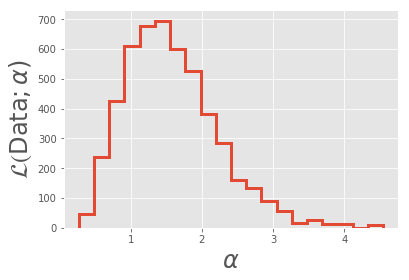

In [18]:
# # test for negative class
# # initial guess for alpha and beta as array.
# prior_c0_init = priors_init[0]
# # Prepare storing MCMC chain as array of arrays.
# A = [prior_c0_init]

# # define stepsize of MCMC.
# stepsizes = [1,10000]  # array of stepsizes
# accepted  = 0.0

# # Metropolis-Hastings with 1000 iterations.
# for n in range(10000):
#     old_prior  = A[len(A)-1]  # old parameter value as array
#     old_obj = objective(old_prior,n_c0,k_c0)
    
#     # Suggest new candidate from Gaussian proposal distribution.
#     new_prior = np.zeros([len(old_prior)])
    
#         # Use stepsize provided for every dimension.
# #         new_prior[i] = random.normal(old_prior[i], stepsizes[i],1)
#     new_prior[0] = random.uniform(abs(old_prior[0]-1),abs(old_prior[0]+1))
#     new_prior[1] = random.uniform(abs(old_prior[1]-1000),abs(old_prior[1]+1000))
        
#     new_obj = objective(new_prior,n_c0,k_c0)
    
#     # Accept new candidate in Monte-Carlo fashing.
#     if (new_obj > old_obj):
#         A.append(new_prior.tolist())
#         accepted = accepted + 1.0  # monitor acceptance
#         print('new_obj>old_obj,',new_prior,new_obj)
#     else:
#         u = random.uniform(0.0,1.0,1)
#         if u < np.exp(new_obj-old_obj):
#             A.append(new_prior.tolist())
#             accepted = accepted + 1.0  # monitor acceptance
#             print('u<p,',new_prior,new_obj)
#         else:
#             print('Rejected')
#             A.append(old_prior)

# print ("Acceptance rate = "+str(accepted/10000.0))
# # Discard first half of MCMC chain and thin out the rest.
# Clean = []
# for n in range(5000,10000):
#     #if (n % 10 == 0):
#         Clean.append(A[n])

# # Print Monte-Carlo estimate of alpha.
# print ("Mean:  "+str(np.mean(np.array(Clean)[:,0])))
# print ("Sigma: "+str(np.std(np.array(Clean)[:,0])))

# plt.figure(1)
# plt.hist(np.array(Clean)[:,0], 20, histtype='step', lw=3)

# plt.xlabel(r'$\alpha$', fontsize=24)
# plt.ylabel(r'$\cal L($Data$;\alpha)$', fontsize=24)
# #lt.savefig('example-MCMC-results.png')
# plt.show()

In [6]:
LOOCV_MAP(train_origin,count_df,0.2,priors_init,prior_init_metropolis)

priors initialization:  [[3.01884109580778, 74719.6422468529], [31.437343977657992, 49152.4340131578]]
priors_c0: [2.75569103e+00 7.47196418e+04] priors_c1: [3.13954582e+01 4.91524046e+04]
Length of associated TCRs in this round: 69
test sample:  RA47  unique_TCRs:  16495  associated_TCRs:  4
y_true: 1  y_pred: 1  y_proba_c1: 0.904

priors initialization:  [[1.8671063541981445, 75869.31168714326], [31.838388695684493, 94633.61249486067]]
priors_c0: [1.62850835e+00 7.58692885e+04] priors_c1: [3.21070474e+01 9.46335148e+04]
Length of associated TCRs in this round: 31
test sample:  HC9  unique_TCRs:  14907  associated_TCRs:  2
y_true: 0  y_pred: 1  y_proba_c1: 0.873

priors initialization:  [[1.3519063553282176, 36951.45407376041], [32.960267920750546, 54436.1294940672]]
priors_c0: [1.24427786e+00 3.69514539e+04] priors_c1: [3.30000842e+01 5.44360500e+04]
Length of associated TCRs in this round: 65
test sample:  RA29  unique_TCRs:  22462  associated_TCRs:  4
y_true: 1  y_pred: 0  y_proba_

priors initialization:  [[1.9478433844022445, 48159.73186040684], [20.41178085471059, 32893.33766974869]]
priors_c0: [1.78668139e+00 4.81597305e+04] priors_c1: [2.03078677e+01 3.28933215e+04]
Length of associated TCRs in this round: 66
test sample:  RA5  unique_TCRs:  8581  associated_TCRs:  3
y_true: 1  y_pred: 1  y_proba_c1: 0.980

priors initialization:  [[1.3743995999310397, 33384.101308405036], [23.724125856008705, 39787.270432764926]]
priors_c0: [1.26211136e+00 3.33841011e+04] priors_c1: [2.36350236e+01 3.97872421e+04]
Length of associated TCRs in this round: 62
test sample:  RA48  unique_TCRs:  23112  associated_TCRs:  5
y_true: 1  y_pred: 1  y_proba_c1: 0.787

priors initialization:  [[1.502320489916798, 36284.80581703073], [22.90301268977363, 36812.518360235255]]
priors_c0: [1.36389138e+00 3.62848057e+04] priors_c1: [2.28669671e+01 3.68125071e+04]
Length of associated TCRs in this round: 67
test sample:  RA6  unique_TCRs:  7346  associated_TCRs:  3
y_true: 1  y_pred: 1  y_prob

priors initialization:  [[2.6334308553636663, 67905.61314331357], [24.223956437479316, 65485.59338884018]]
priors_c0: [2.37914211e+00 6.79056128e+04] priors_c1: [2.43149407e+01 6.54855269e+04]
Length of associated TCRs in this round: 32
test sample:  HC14  unique_TCRs:  14395  associated_TCRs:  2
y_true: 0  y_pred: 1  y_proba_c1: 0.772

priors initialization:  [[1.6125401105927977, 58314.126158262145], [35.02287526469248, 106974.13293945392]]
priors_c0: [1.44343827e+00 5.83141260e+04] priors_c1: [3.52177792e+01 1.06974014e+05]
Length of associated TCRs in this round: 30
test sample:  HC5  unique_TCRs:  10600  associated_TCRs:  0
y_true: 0  y_pred: 0  y_proba_c1: 0.131

priors initialization:  [[0.8854162191468904, 19678.332775640745], [25.27788623725609, 40164.352192929124]]
priors_c0: [8.85416219e-01 1.96783328e+04] priors_c1: [2.53752749e+01 4.01642348e+04]
Length of associated TCRs in this round: 69
test sample:  RA16  unique_TCRs:  4701  associated_TCRs:  3
y_true: 1  y_pred: 1  y_

priors initialization:  [[1.76977722997261, 43257.042051144526], [18.81741320170482, 29655.81797598424]]
priors_c0: [1.61100476e+00 4.32570418e+04] priors_c1: [1.87353205e+01 2.96558067e+04]
Length of associated TCRs in this round: 68
test sample:  RA30  unique_TCRs:  6572  associated_TCRs:  2
y_true: 1  y_pred: 1  y_proba_c1: 0.938

priors initialization:  [[2.7734198474950658, 70604.07907393368], [58.353405624395215, 99113.00069924536]]
priors_c0: [2.60411181e+00 7.06040788e+04] priors_c1: [5.78192000e+01 9.91122225e+04]
Length of associated TCRs in this round: 62
test sample:  RA24  unique_TCRs:  19594  associated_TCRs:  6
y_true: 1  y_pred: 1  y_proba_c1: 0.992

priors initialization:  [[1.4366135809347533, 33980.30350093522], [45.7841854655277, 100844.56792814909]]
priors_c0: [1.32668788e+00 3.39803021e+04] priors_c1: [4.61198455e+01 1.00844355e+05]
Length of associated TCRs in this round: 40
test sample:  HC11  unique_TCRs:  42732  associated_TCRs:  12
y_true: 0  y_pred: 1  y_pro

(0.5838461538461539, 0.9993675298015444)